In [1]:
! pip install scipy -U
! pip install pmdarima
! pip install fbprophet
! pip install hvplot
! pip install tsfresh
! pip install gluonts
! pip install mxnet

     |████████████████████████████████| 27.4MB 151kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 1.5MB 6.3MB/s 
     |████████████████████████████████| 9.5MB 150kB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 3.1MB 7.7MB/s 
     |████████████████████████████████| 102kB 6.4MB/s 
     |████████████████████████████████| 1.1MB 15.1MB/s 
     |████████████████████████████████| 706kB 27.1MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 112kB 34.6MB/s 
     |████████████████████████████████| 1.3MB 24.7MB/s 
ERROR: googleapis-common-protos 1.53.0 has requirement protobuf>=3.12.0,

     |████████████████████████████████| 901kB 7.6MB/s 
     |████████████████████████████████| 10.1MB 14.5MB/s 
     |████████████████████████████████| 46.9MB 87kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>Sberbank stock price prediction models</h1>
</div>

I decided to use 3-year Sberbank stock prices from their official cite:

https://www.sberbank.com/ru/investor-relations/share-profile/stock-chart-and-performance-calculator

since Sberbank is a large company, I do not assume that there will be a large number of anomalies (such as with cryptocurrency), while the company is actively traded on the exchange, so predicting their quotes is a rather useful exercise

We will predict **Close** prices.

### Content:
1. Load the Data
  - Import libraries
  - Load the datasets
  
2. Overview of the Data
  - Descriptive Statistics
  - Missing Values

3. Exploratory Data Analysis and Data Preparation
  - Visualize the time series using line plot
  - Check distribution of the time series
  - Check monthly seasonality using multiple lines
  - Plot moving average and confidence intervals
  - Plot exponential smoothing
  - Plot double exponential smoothing
  - Holt-Winters exponential smoothing and detect anomalies
  - Check monthly seasonality and yearly trend using box plot
  - Decompose the time series
  - Stationarity test - Augmented Dickey Fuller test (ADH Test)
  - ACF-PACF plots and Find the order of differencing 
  
4. Model Building
  - Transform the data using box-cox transformation
  - Split data in train-test dataset
  - Model 1 - ARIMA
  - Model 2 - SARIMA
  - Model 3 - SARIMAX
  - Model 4 - Simple Exponential Smoothing
  - Model 5 - Holt-Winters
  - Define function to evaluate models
  - Train and evaluate the model
  - Save the model

5. Classic ML with feature engineering (normal or tsfresh)
  - usual ML model with default feature engineering
  - tsfresh feature engeneering

6. Prophet library

7. GluonTS (deep learning Amazon)

8. Manual Deep learning Model (LSTM)

9. Compare results

10. Usefull functions

## Inputs

In [1]:
# Input file name with path
input_file_name = 'https://github.com/serzaraisk/time_series-template/blob/794c83cc8a27df7410c1820b560f0938852485a2/Sberbank_3_years_stock_prices.csv?raw=true'

# Target class name
input_target_variable = 'Close'

# Date column name
input_date_variable = 'Date'

# Exogenous variable
input_exogenous_variable = ['Open', 'Max', 'Min']

## 1.Load data 

In this section we will:

- Import the libraries
- Load the dataset

### 1.1. Import Libraries

Import all the libraries in the first cell itself

In [2]:
# Import libraries 

# Data Manipulation
import numpy as np 
import pandas as pd
from   pandas import DataFrame
from pandas.plotting import lag_plot
import panel as pn 

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Statistics
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from fbprophet import Prophet

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

from dateutil.parser import parse 
import pickle

from scipy.optimize import minimize  # for function minimization
from tqdm import tqdm_notebook

# Set the options
sns.set()
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.rcParams.update({'figure.figsize': (12, 8), 'figure.dpi': 120})

In [3]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 1.2. Load the datasets

Load the dataset using pd.read_csv()

In [4]:
# Read data in form of a csv file
df = pd.read_csv(input_file_name)

df[input_date_variable] = pd.to_datetime(df[input_date_variable], format='%d.%m.%Y')
df.sort_values(input_date_variable, inplace=True)

# First 5 rows of the dataset
df.head()

Date    Open     Max     Min   Close
0 2018-05-23  223.11  224.07  221.00  221.00
1 2018-05-24  221.91  223.70  221.12  222.01
2 2018-05-25  222.51  223.48  219.00  220.00
3 2018-05-28  219.47  221.50  219.20  220.90
4 2018-05-29  220.50  222.13  217.10  219.00

In [5]:
# also created monthly dataframe for smoothing some graphs
df_monthly = df.set_index('Date').resample('M').mean()
df_monthly

Open         Max         Min       Close
Date                                                      
2018-05-31  221.254286  222.968571  219.328571  220.897143
2018-06-30  211.859474  214.694211  209.244211  211.862105
2018-07-31  218.872727  221.613182  215.715000  218.818182
2018-08-31  192.213913  194.750435  187.917391  190.909130
2018-09-30  185.835500  189.224000  183.467000  186.576000
2018-10-31  190.241739  193.043913  186.627826  189.655217
2018-11-30  195.976667  198.512857  193.294286  196.070952
2018-12-31  189.352381  191.160952  187.210000  189.240952
2019-01-31  202.364000  204.954000  201.050000  203.583000
2019-02-28  210.141500  212.061000  207.656500  209.689000
2019-03-31  208.059500  209.875500  206.566000  208.238500
2019-04-30  230.979091  233.401364  228.492273  230.880909
2019-05-31  230.201429  232.906190  228.166667  230.749048
2019-06-30  239.679474  242.715789  237.417368  240.518421
2019-07-31  237.456957  239.078696  235.220870  236.998261
2019-08-31  220.971364  222.802727  218.576364  220.411364
2019-09-30  230.796667  232.315714  228.936667  230.752857
2019-10-31  232.121739  234.060870  230.246957  232.320435
2019-11-30  237.995000  239.538500  236.122500  237.942000
2019-12-31  241.158571  243.123333  239.769048  241.853333
2020-01-31  259.781500  262.075500  257.354500  259.728500
2020-02-29  251.097895  253.102105  248.548421  250.596842
2020-03-31  199.654286  204.947619  192.291429  198.319524
2020-04-30  192.224545  194.798636  189.585909  192.443636
2020-05-31  192.861579  195.116842  190.874211  192.855789
2020-06-30  209.529500  212.209000  206.838500  209.714000
2020-07-31  212.896364  215.160909  210.427273  213.613182
2020-08-31  231.109130  233.540870  228.342174  230.950870
2020-09-30  225.599667  227.588000  223.059000  225.503667
2020-10-31  208.485806  210.212581  205.872581  207.799032
2020-11-30  234.355517  237.795862  231.701379  235.958621
2020-12-31  271.939667  275.329333  268.951000  272.688333
2021-01-31  275.553704  278.994815  271.001481  274.442593
2021-02-28  268.483462  271.483462  265.501538  269.323462
2021-03-31  283.976667  287.415667  281.156000  284.835667
2021-04-30  289.034333  291.216000  286.587333  289.213667
2021-05-31  304.082105  306.658947  300.938947  304.504211

## 2.Overview of the Data</h2>

In this section we will:
- Get the descriptive statistics of the data
- Get the information about missing values in the data

### 2.1. Descriptive Statistics

As the name says descriptive statistics describes the data. It gives you information about
- Mean, median, mode 
- Min, max
- Count etc

Let's understand the data we have

In [6]:
# Dimension of the data
df.shape

(826, 5)

In [7]:
# Summary of the dataset
df.describe(datetime_is_numeric=True)

Date        Open         Max         Min  \
count                            826  826.000000  826.000000  826.000000   
mean   2019-12-25 17:43:26.295412224  230.053692  232.578547  227.361550   
min              2018-05-23 00:00:00  170.200000  172.670000  165.900000   
25%              2019-03-18 06:00:00  205.455000  207.855000  203.297500   
50%              2020-01-11 12:00:00  227.160000  229.130000  225.050000   
75%              2020-10-15 18:00:00  248.312500  250.302500  246.427500   
max              2021-05-23 00:00:00  316.000000  319.160000  315.480000   
std                              NaN   31.887193   31.909088   31.864101   

            Close  
count  826.000000  
mean   230.130581  
min    169.360000  
25%    205.425000  
50%    227.165000  
75%    248.950000  
max    317.940000  
std     32.010152

### 2.2. Missing Values

Get the info about missing values in the dataframe

In [8]:
# Missing values for every column
df.isna().sum()

Date     0
Open     0
Max      0
Min      0
Close    0
dtype: int64

__Step's conclusion__

Dataset doesn't contain any missing values, so we don't need any preprocessing steps.

## 3.Exploratory Data Analaysis</h2>

Exploratory data analysis is an approach to analyze or investigate data sets to find out patterns in the data. Visual methods are often used to summarise the data. Primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing tasks.

In this section we will:
  - Visualize the time series using line plot
  - Check distribution of the time series
  - Check monthly seasonality using multiple lines
  - Plot moving average and confidence intervals
  - Plot exponential smoothing
  - Plot double exponential smoothing
  - Holt-Winters exponential smoothing and detect anomalies
  - Check monthly seasonality and yearly trend using box plot
  - Decompose the time series
  - Stationarity test - Augmented Dickey Fuller test (ADH Test)
  - ACF-PACF plots and Find the order of differencing 

### 3.1. Visualize the time series using line plot

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:
- Whether the trend appears to be level around the mean
- Whether there appear to be any obvious outliers

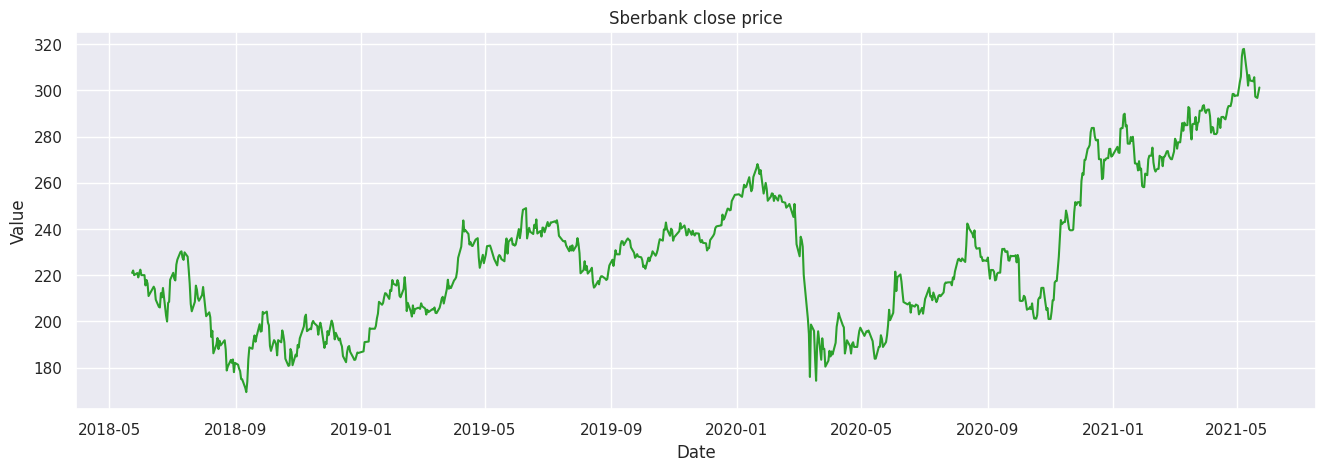

In [9]:
# Draw line Plot
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:green')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=df[input_date_variable], y=df[input_target_variable], title='Sberbank close price')

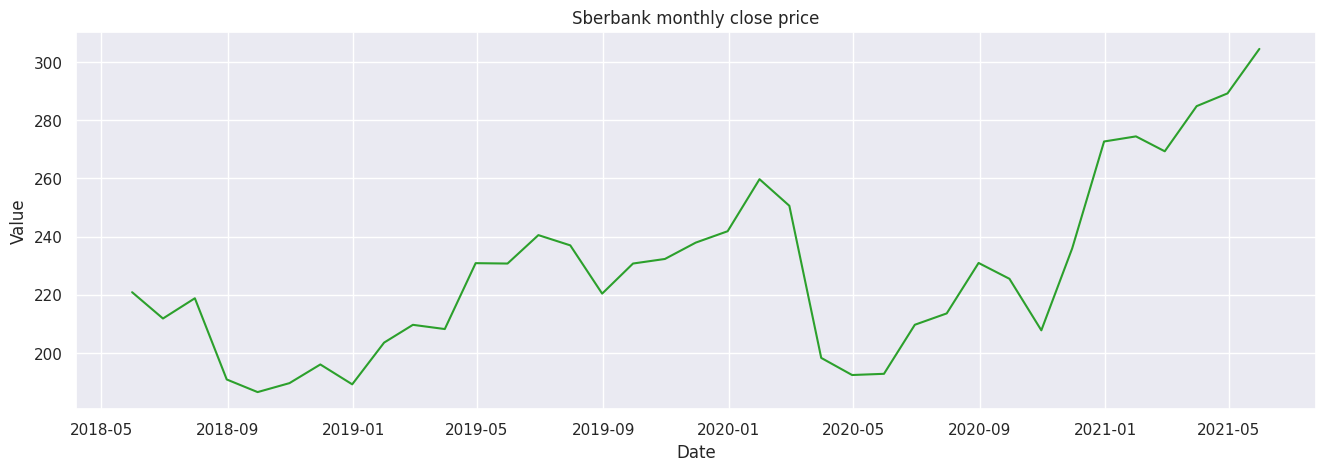

In [10]:
plot_df(x=df_monthly.index, y=df_monthly[input_target_variable], title='Sberbank monthly close price')

__Step's coclusion__

For Sberbank shares, you can see:
- clearly increasing trend
- seasonality is not visible on the current graph
- In February-March, some kind of anomaly clearly occurred, which greatly lowered the price of Sberbank shares.

### 3.2. Check distribution of the time series

We should check the distribution of the time series so that you can decide if you need to transform the data or can be used as it is. Additionally, it provides insights about the type of distribution the data follows

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



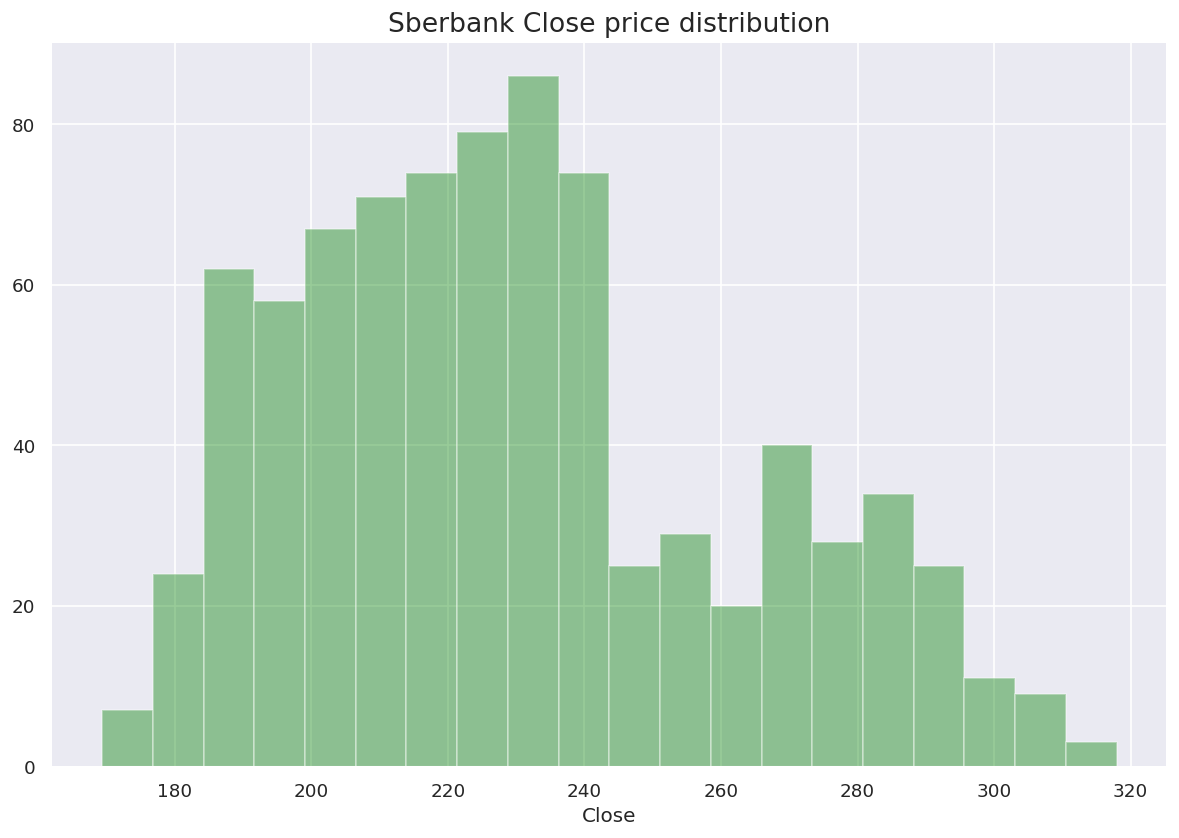

In [11]:
sns.distplot(df[input_target_variable], kde = False, color ='green', bins = 20)
plt.title('Sberbank Close price distribution', fontsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



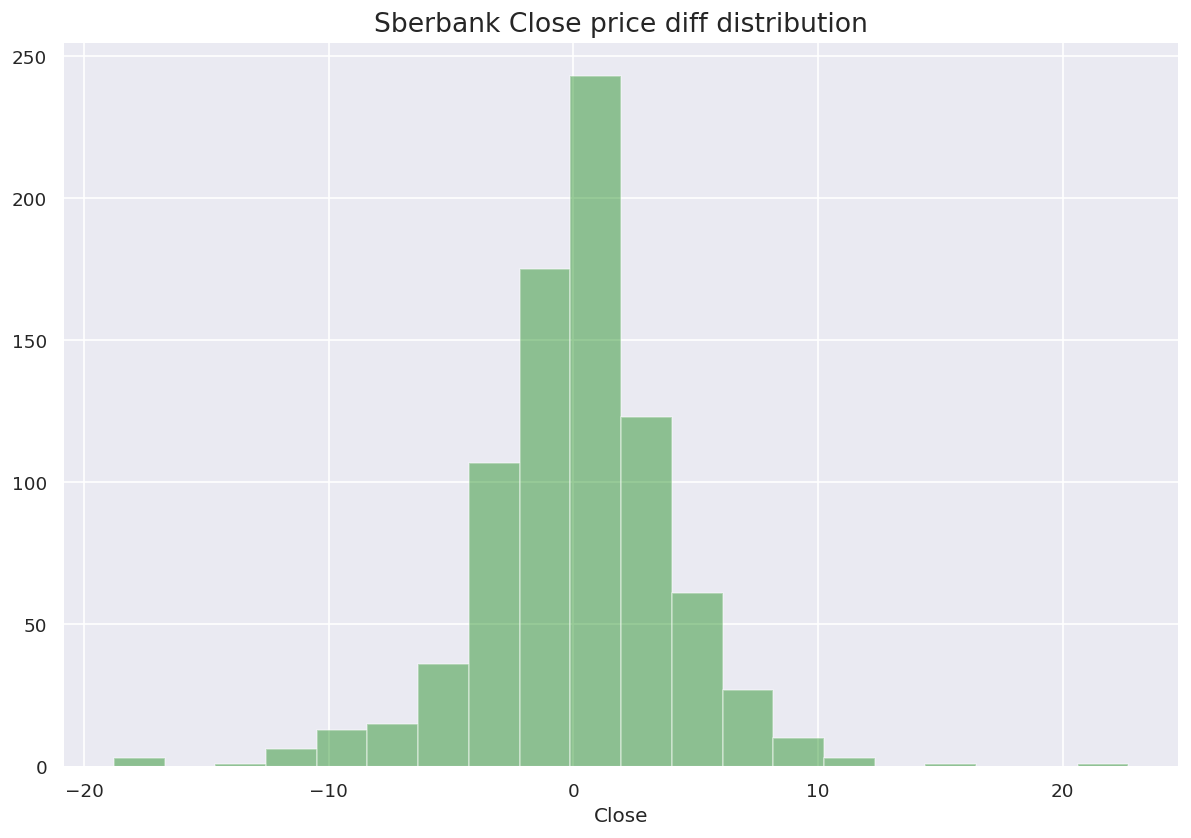

In [12]:
sns.distplot(df[input_target_variable].diff(), kde = False, color ='green', bins = 20)
plt.title('Sberbank Close price diff distribution', fontsize=16)
plt.show()

__Step's coclusion__

According to the distribution graph of the closing price, it can be seen that the graph is scewed to the right, which is logical, since the price began to rise above the average (240) only in the 2021.

Price Differences has normal distribution, with some outliers on the left. 

### 3.3. Check monthly seasonality using multiple lines

In [13]:
def plot_timeseries_divided(df, target_series_name, devided_series_name,  x_series_name, title):

    periods = df[devided_series_name].unique()

    # Prep Colors
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(periods), replace=False)

    # Draw Plot
    plt.figure(figsize=(16,8), dpi= 80)
    for i, y in enumerate(periods):
        if i> 0:
            plt.plot(x_series_name, target_series_name, data=df.loc[df[devided_series_name]==y, :], color=mycolors[i], label=y)
            plt.text(df.loc[df[devided_series_name]==y, :].shape[0]-.9, df.loc[df[devided_series_name]==y, target_series_name][-1:].values[0], y, fontsize=12, color=mycolors[i])

    # Decoration
    plt.gca().set(ylabel=target_series_name, xlabel=x_series_name)
    num_ticks=len(df[x_series_name].unique())
    plt.yticks(fontsize=10, alpha=.7)
    plt.title(title, fontsize=20)
    plt.show()

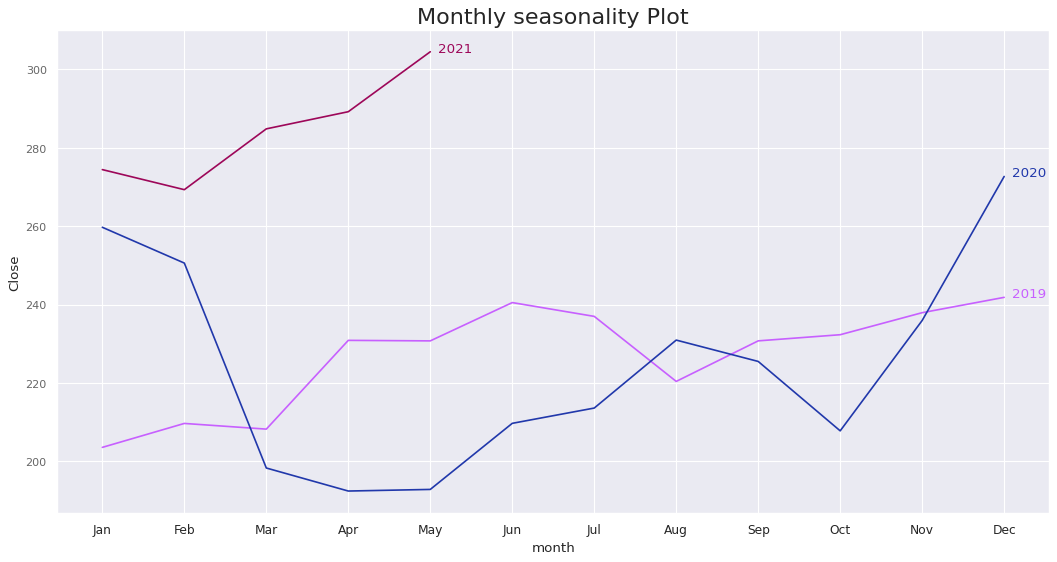

In [14]:
df_monthly.reset_index(inplace=True)
df_monthly['year'] = [d.year for d in df_monthly[input_date_variable]]
df_monthly['month'] = [d.strftime('%b') for d in df_monthly[input_date_variable]]
plot_timeseries_divided(df_monthly, input_target_variable, 'year', 'month', 'Monthly seasonality Plot')

__Step's coclusion__

Again, we can't see any monthly seasonality in the plot.

The beggining of the 2021 can be compared with the shifted version of the 2019

### 3.4. Plot moving average with confidence intervals

In [15]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


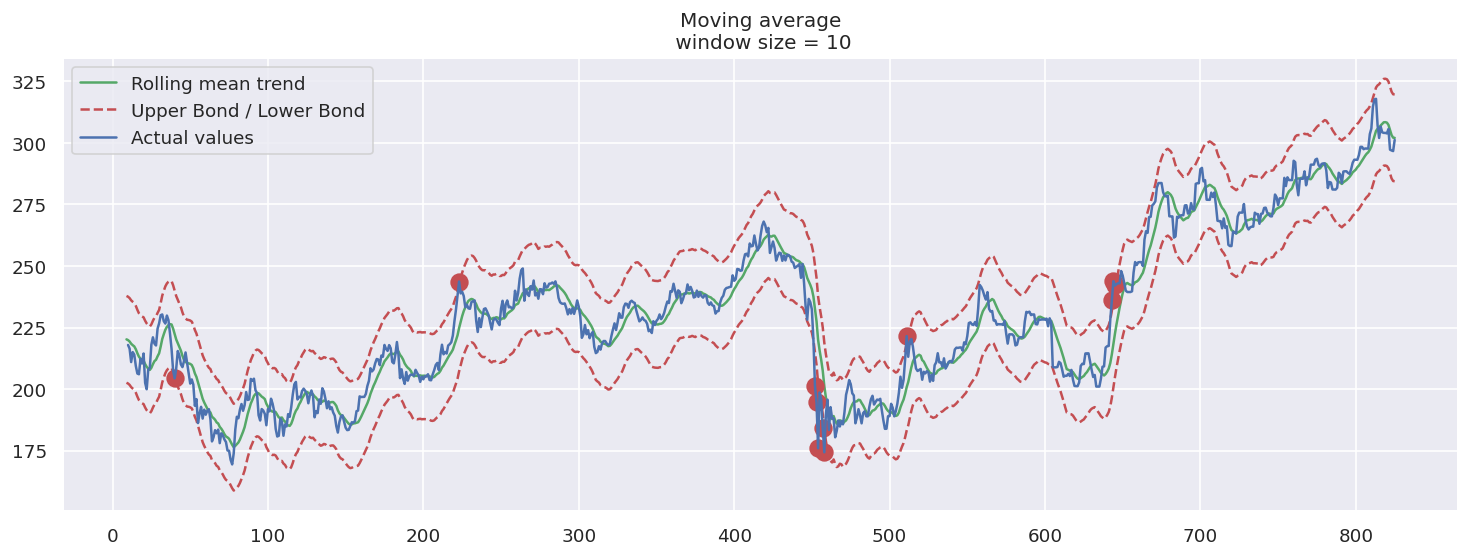

In [16]:
plotMovingAverage(df[[input_target_variable]], 10, plot_intervals=True, plot_anomalies=True)

__Step's coclusion__

Moving average was able to capture general trend of the time series: As we can see, there are 7-8 anomalies, which goes beyond 3 confidence intervals

### 3.5. Plot exponential smoothing 


$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function – we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [17]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [18]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        plt.plot(series.values, "green", label = "Actual")
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

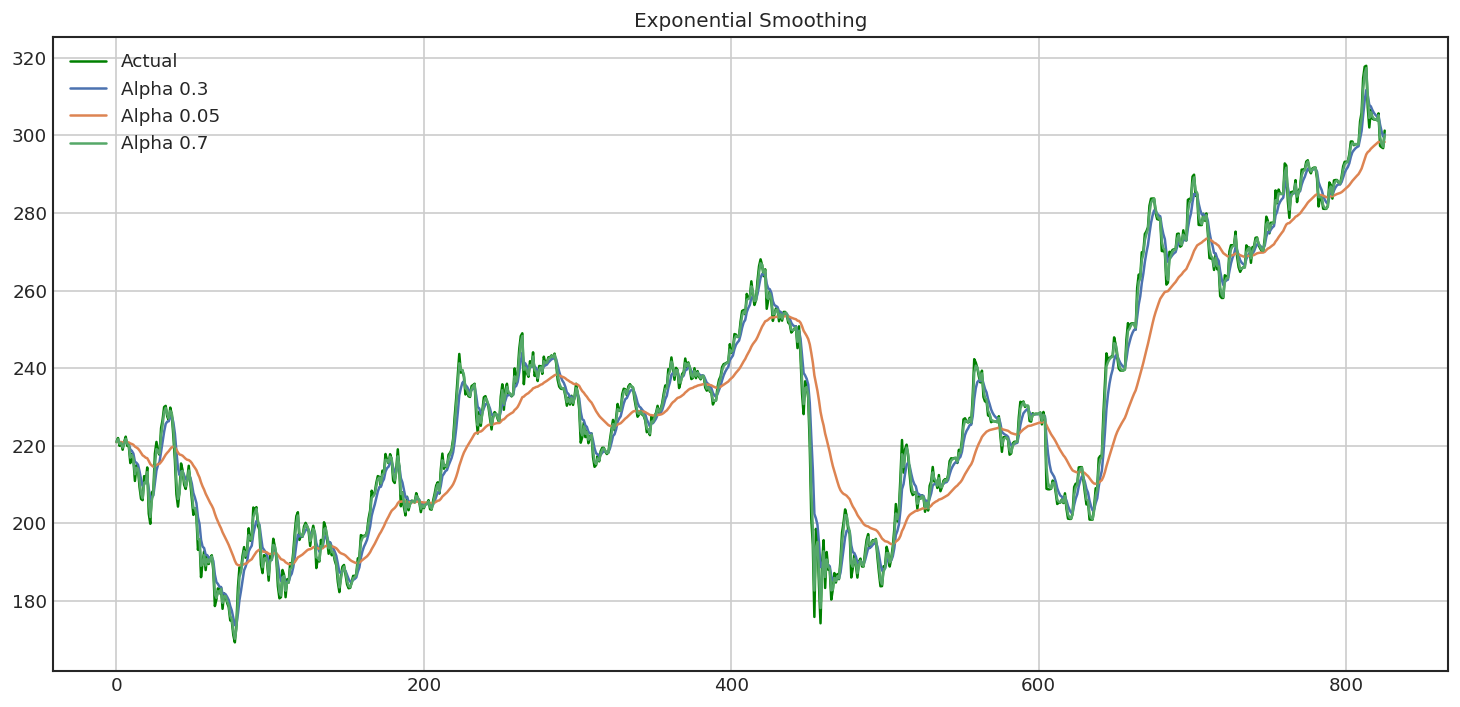

In [19]:
plotExponentialSmoothing(df[input_target_variable], [0.3, 0.05, 0.7])

__Step's coclusion__

Exponential smoothing  was also able to capture general trend of the time series: Small alpha obviously doesn't catch up flucluations, so It's seems that bigger alpha, like 0.3 and 0.7 gives better results.

### 3.8. Plot double exponential smooting

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [20]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """

    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(
                    double_exponential_smoothing(series, alpha, beta),
                    label="Alpha {}, beta {}".format(alpha, beta),
                )
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

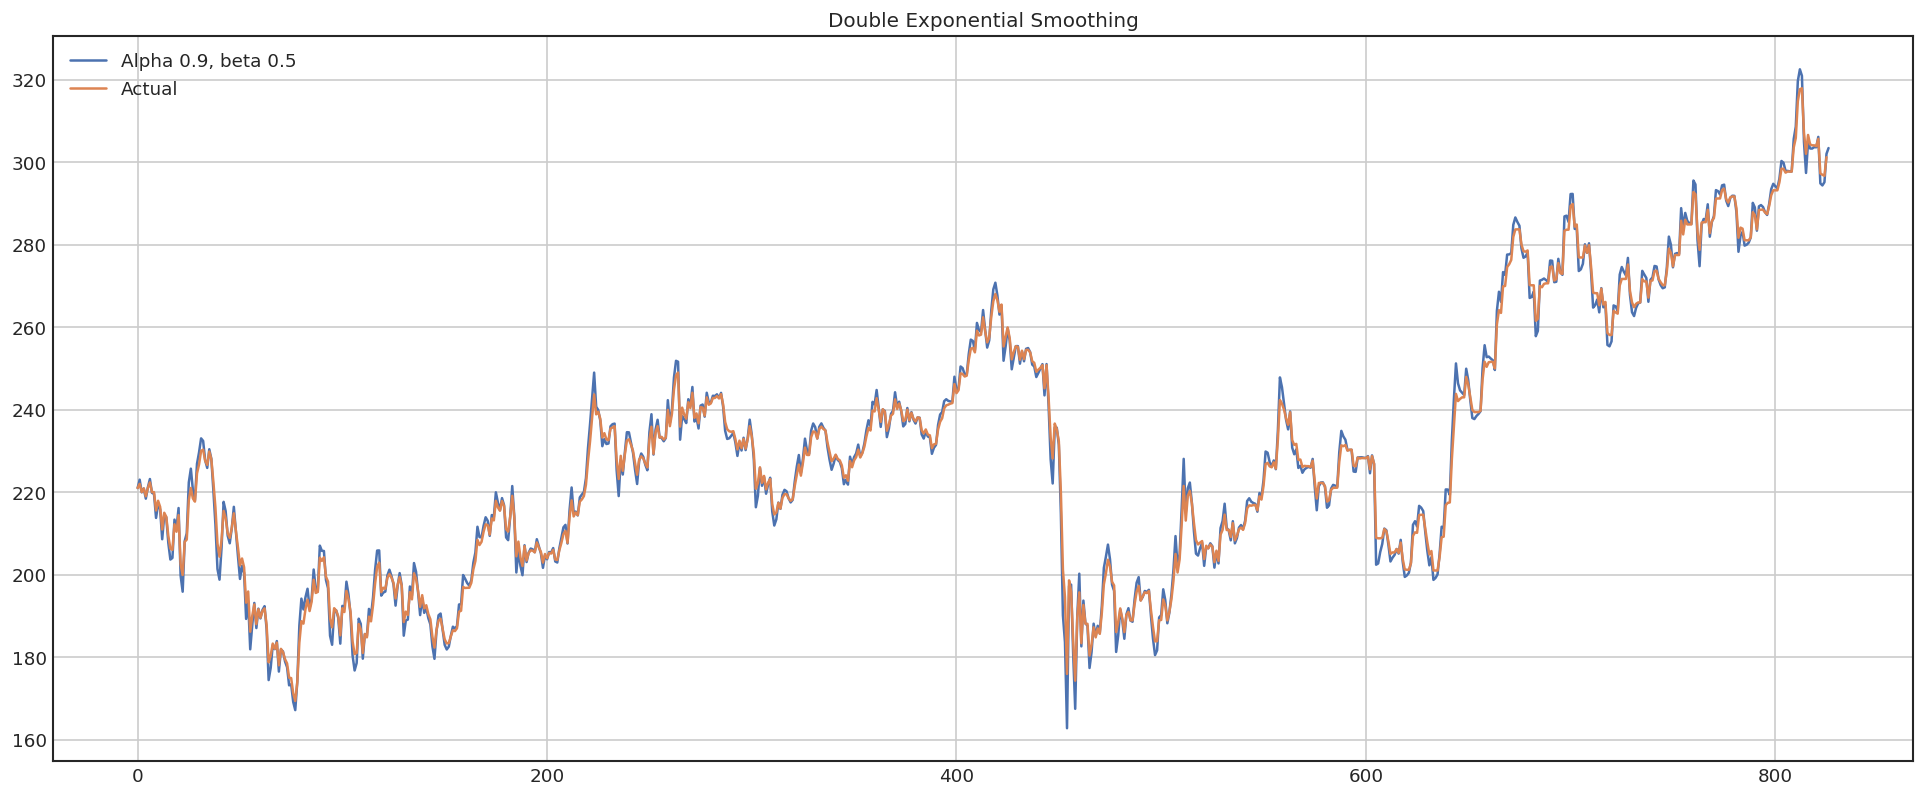

In [21]:
plotDoubleExponentialSmoothing(df[input_target_variable], alphas=[0.9], betas=[0.5])

__Step's coclusion__

It can be seen that exponential smoothing was able to repeat the original chart of stock prices: you can see from the chart that smoothing is wrong only in abnormally strong drawdowns

### 3.9. Seasonality and Yearly Trend using Box Plot

We can check the yearly trend and monthly seasonality using a box plot.

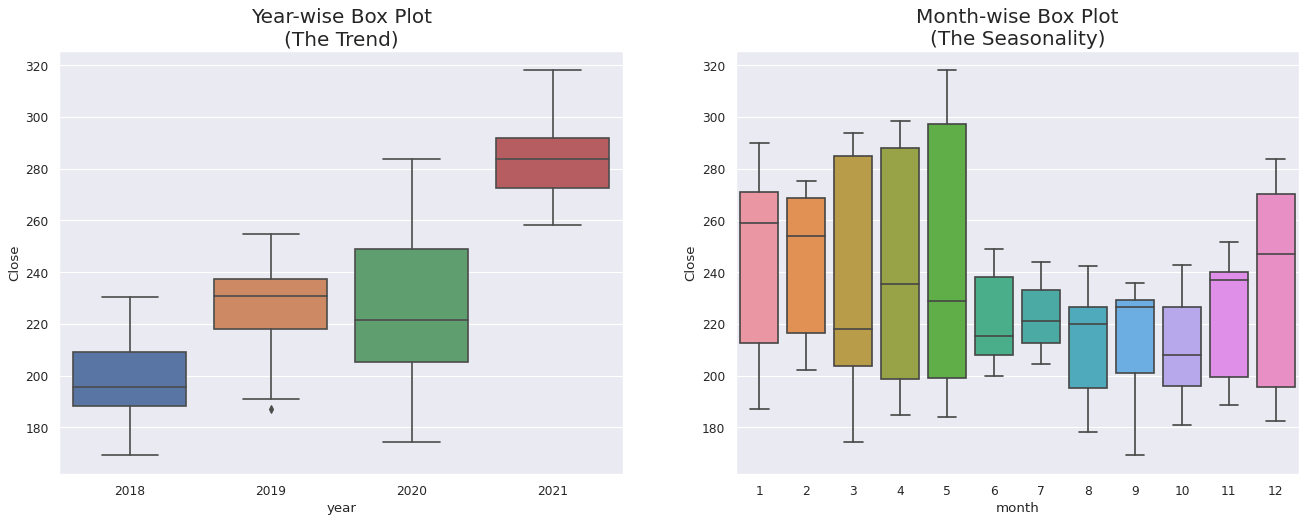

In [22]:
# Draw Plot
df['month'] = df[input_date_variable].dt.month
df['year'] = df[input_date_variable].dt.year
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y=input_target_variable, data=df, ax=axes[0])
sns.boxplot(x='month', y=input_target_variable, data=df)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

__Step's coclusion__

On the graphs we see:
1. Additional confirmation of the increasing trend
2. The largest price deviation was in 2020
3. In terms of months, the largest deviation occurs in the first half of the year and the last month of the year, in the second half of the year the price is quite stable

### 3.10. Time Series Decomposition

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

Additive time series:
- Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
- Value = Base Level x Trend x Seasonality x Error

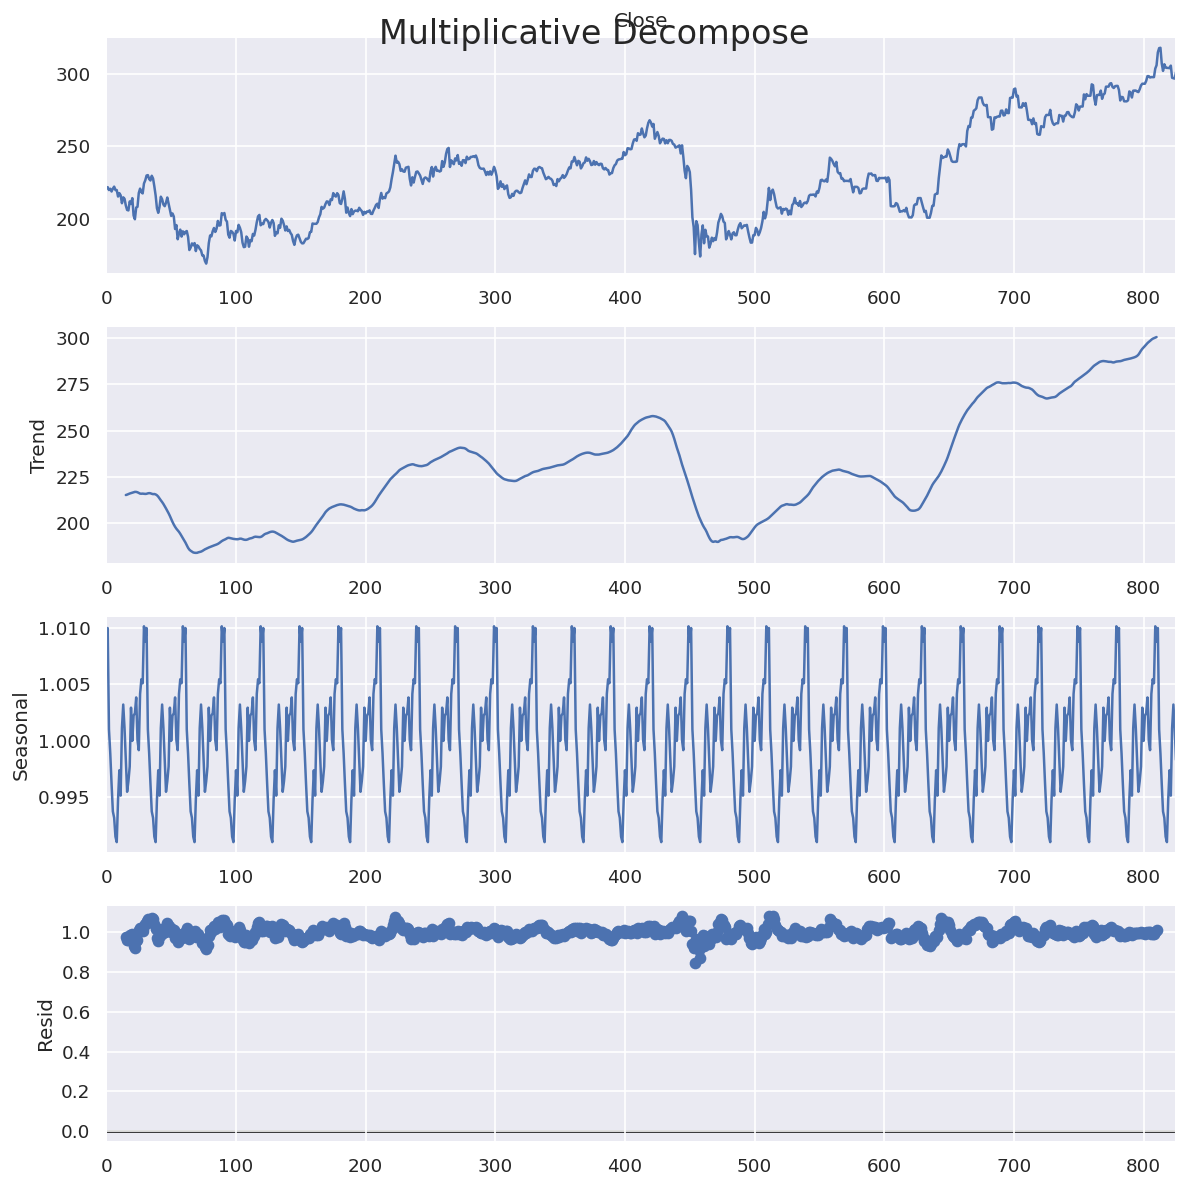

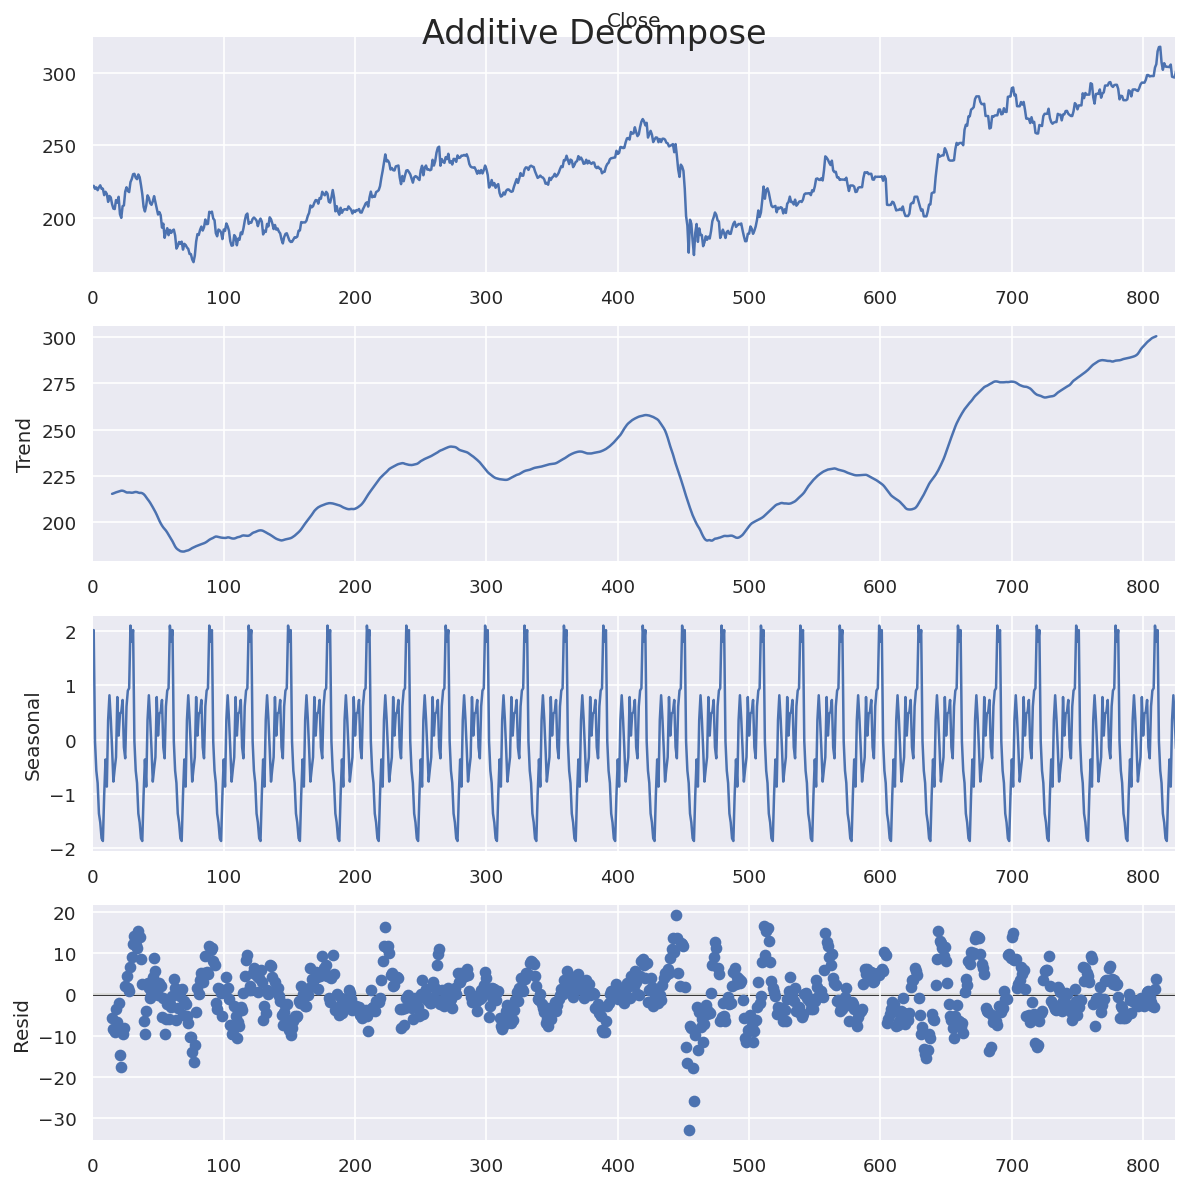

In [23]:
# Multiplicative Decomposition 
input_seasonality = 30
result_mul = seasonal_decompose(df[input_target_variable], model='multiplicative', period=input_seasonality)

# Additive Decomposition
result_add = seasonal_decompose(df[input_target_variable], model='additive', period=input_seasonality)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)
plt.show()

__Step's coclusion__

Both decompositions cannot highlight seasonality in the charts (errors are greater than seasonality). The multiplicative model looks more stable.

### 3.11 Stationarity test - Augmented Dickey Fuller test (ADH Test)

There are mulitple tests to test if a time series is stationary or not.

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test. The below code implements these two tests using statsmodels package in python.

In [24]:
# ADF Test
result = adfuller(df[input_target_variable].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.0835458530404145
p-value: 0.721588827536342
Critial Values:
   1%, -3.438399099271788
Critial Values:
   5%, -2.8650928286782857
Critial Values:
   10%, -2.568661836350634


In [25]:
# KPSS Test
result = kpss(df[input_target_variable].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 1.911091
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




__Step's coclusion__

Since our data have a pronounced trend, it is obvious that both methods showed that the series is not stationary.

### 3.12. ACF-PACF plots and Find the order of differencing 

**How to find the order of differencing?**

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

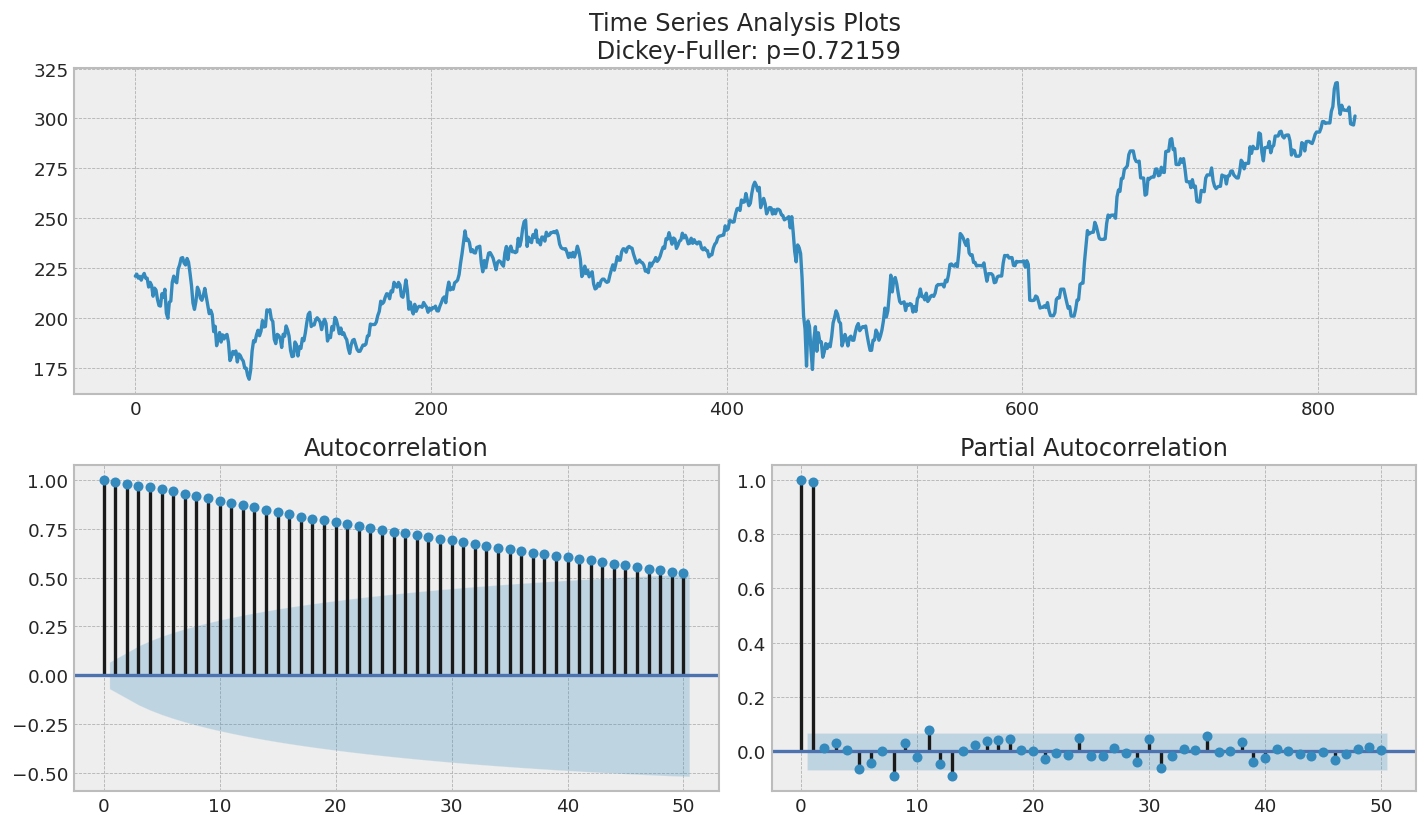

In [27]:
tsplot(df[input_target_variable], lags=50)

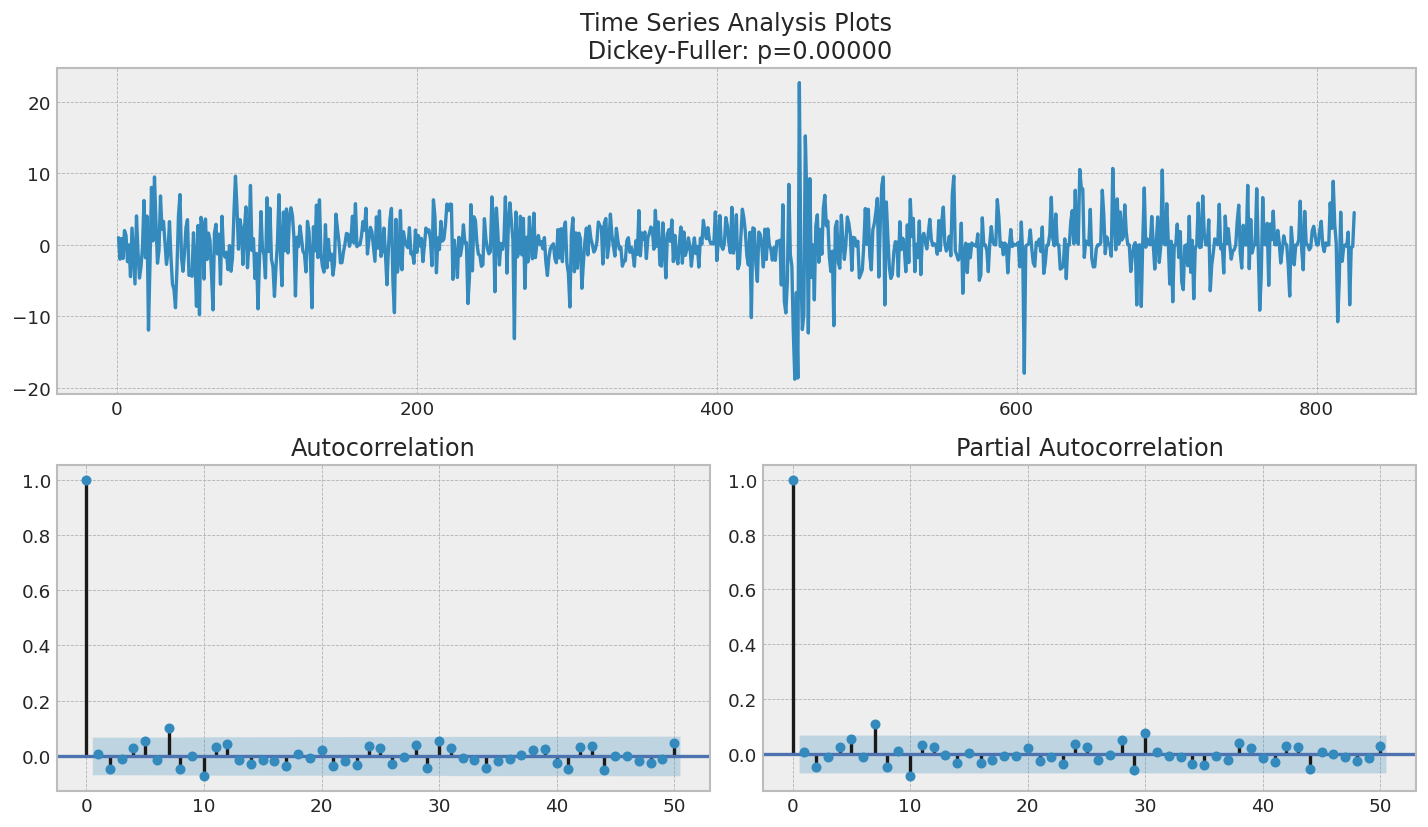

In [28]:
tsplot(df[input_target_variable].diff().dropna(), lags=50)

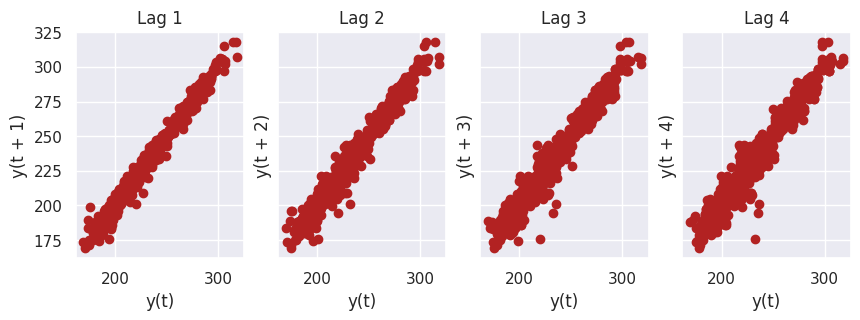

In [29]:
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df[input_target_variable], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

In [30]:
## Adf Test
print('Adf Test: ', ndiffs(df[input_target_variable], test='adf'))
# KPSS test
print('KPSS test: ', ndiffs(df[input_target_variable], test='kpss')) 
# PP test:
print('PP test: ', ndiffs(df[input_target_variable], test='pp'))

Adf Test:  1
KPSS test:  1
PP test:  1


__Step's coclusion__

To transform a series into a stationary one, one differentiation is required. The partial autocorrelation plots clearly show that lag 1 is very strongly correlated with the current price (that is, the stock price today is largely determined by the stock price today).

## 4.Model Building

In this section we will:
- Split data in train-test dataset
- Model 1 - ARIMA
- Model 2 - SARIMA
- Model 3 - SARIMAX
- Model 4 - Simple Exponential Smoothing
- Model 5 - Holt-Winters
- Define function to evaluate models
- Train and evaluate the model
- Save the model

### 4.2. Train - Test Window Split

For testing puproses we will take last 2 months.

Also we will train only on one last year, as Sberbank share prices had drastically descrease in the beginning of 2020 year, which looks like anomaly.

In [31]:
train, test = df[(df[input_date_variable] < '2021-04-01') & (df[input_date_variable] > '2020-04-01')], df[df[input_date_variable] >= '2021-04-01']

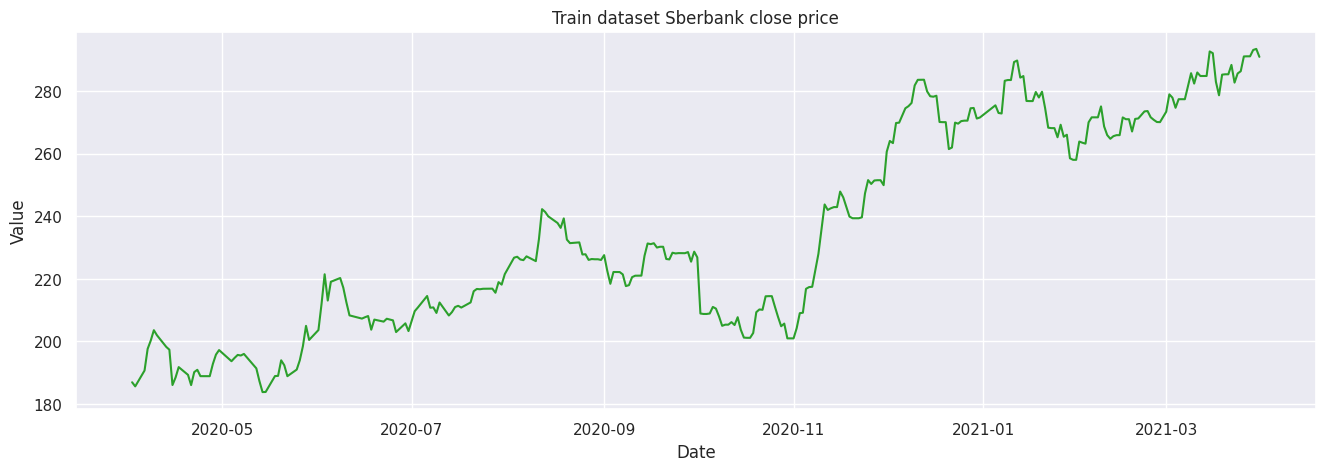

In [32]:
plot_df(x=train[input_date_variable], y=train[input_target_variable], title='Train dataset Sberbank close price')

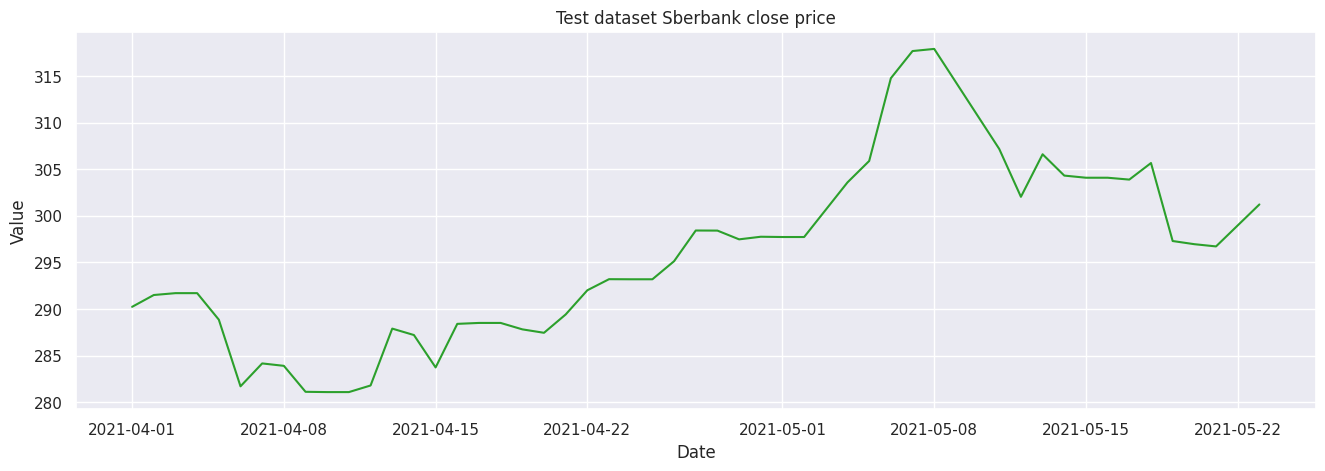

In [33]:
plot_df(x=test[input_date_variable], y=test[input_target_variable], title='Test dataset Sberbank close price')

In [34]:
print('Train shape:', train.shape )
print('Test shape:', test.shape)

Train shape: (308, 7)
Test shape: (49, 7)


### 4.3. Model 1 - ARIMA

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

The initial order of the ARIMA model can be determined using the the ACF and PACF plots. The initial starting point for 'p' is the number of significant lags from the PACF plot and 'q' comes from the number of significant lags from the ACF plot.

### 4.4. Model 2 - SARIMA

If a time series has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

### 4.5. Model 3 - SARIMAX

If a time series has seasonal patterns and an external predictor (also called as exogenous variable), then you need to add seasonal and exogenous terms and it becomes SARIMAX

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

Since ARIMA, SARIMA are from the same family, I have defined a single function to fit these models automatically.

Sarimax won't be used as all columns which we will have has some kind of data leakage, as we can't know all open, min and max prices at the start of the forecasting.

All these models can be trained in pm.autoarima function

In [35]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(train[input_target_variable], exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 5, max_q = 5, m = input_seasonality, 
                          start_P = 0, seasonal = True, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = False, 
                          max_order=5)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

### 4.6. Model 4 - Simple Exponential Smoothing

Single Exponential Smoothing is a time series forecasting algorithm for univariate data which doesn't have a trend or seasonality. Only one parameter is required for SES - alpha (a).  It is the smoothing coefficient.

In [36]:
def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.3,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.6. Model 5 - Double Exponential Smoothing

Double Exponential Smoothing is a time series forecasting algorithm for univariate data which have a trend and doesn't have seasonality.

In [37]:
def model_double_exponential_smoothing(y, type_='add'):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y), trend=type_).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.7. Model 6 - Holt-Winters

Holt-Winters is a time series forecasting algorithm. It models three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality).

You need to pass on the parameter seasonality to it

In [38]:
def model_holt_winters(y, seasonality, type_='add'):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=seasonality ,trend=type_, seasonal=type_).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.8. Define function to get the predictions

In [39]:
def get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

__Step's coclusion__

### 4.9. Define function to evaluate models

- Durbin Watson Statistic
- MAPE
- MAE
- RSME
- R2 Score

In [40]:
def durbin_watson_stat(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    return(durbin_watson(validation_df.error))

In [41]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

In [42]:
def evaluate_model(actuals, predictions, input_target_variable = input_target_variable):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))
    print("Durbin Watson Score : ", durbin_watson_stat(actuals, predictions))
    
    analyse_error(actuals, predictions)
    
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target_variable,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)
    return {'MAPE': mean_absolute_percentage_error(actuals, predictions),
            'RMSE': mean_squared_error(actuals, predictions, squared=False),
            'MAE': mean_absolute_error(actuals, predictions),
            'R2 Score': r2_score(actuals, predictions),
            'Durbin Watson Score': durbin_watson_stat(actuals, predictions)}

__Step's coclusion__

### 4.10. Train and evaluate the model

In [43]:
# Get actual values
def train_and_evaluate_model(input_ts_algo, type_='add'):
    print(input_ts_algo)
    actuals = test[input_target_variable].reset_index(drop = True)

    # Select the algorithm according to the input provided
    if input_ts_algo == 'auto_arima':
        
        print("------------- Auto ARIMA --------------- \n")
        model = model_auto_sarimax(y = train[input_target_variable], seasonality = None, seasonal_flag = False, exogenous_variable = None)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable)
        results = evaluate_model(actuals, predictions)
        
    elif input_ts_algo == 'auto_sarima':
        
        print("------------- Auto SARIMA --------------- \n")
        model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
        results = evaluate_model(actuals, predictions)
        
    elif input_ts_algo == 'auto_sarimax':
        
        print("------------- Auto SARIMAX --------------- \n")
        model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = train[input_exogenous_variable].values)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = test[input_exogenous_variable].values)
        results = evaluate_model(actuals, predictions)

    elif input_ts_algo == 'simple_exponential_smoothing':
        
        print("------------- Simple Exponential Smoothing --------------- \n")
        model = model_simple_exponential_smoothing(y = train[input_target_variable])
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
        results = evaluate_model(actuals, predictions)

    elif input_ts_algo == 'double_exponential_smoothing':
        
        print("------------- double_exponential_smoothing --------------- \n")
        model = model_double_exponential_smoothing(y = train[input_target_variable], type_=type_)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
        results = evaluate_model(actuals, predictions)
        
    elif input_ts_algo == 'holt_winters':
        
        print("------------- Holt Winters --------------- \n")
        model = model_holt_winters(y = train[input_target_variable], seasonality = input_seasonality, type_=type_)
        predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
        results = evaluate_model(actuals, predictions)
    return results

auto_arima
------------- Auto ARIMA --------------- 

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1664.897, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1665.717, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1667.215, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1667.854, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1669.710, Time=0.23 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1670.791, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1665.808, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1666.902, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1668.820, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1669.796, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1671.276, Time=0.59 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1667.421, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1668.795, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(2,1,3)(0,0,0)[1] int

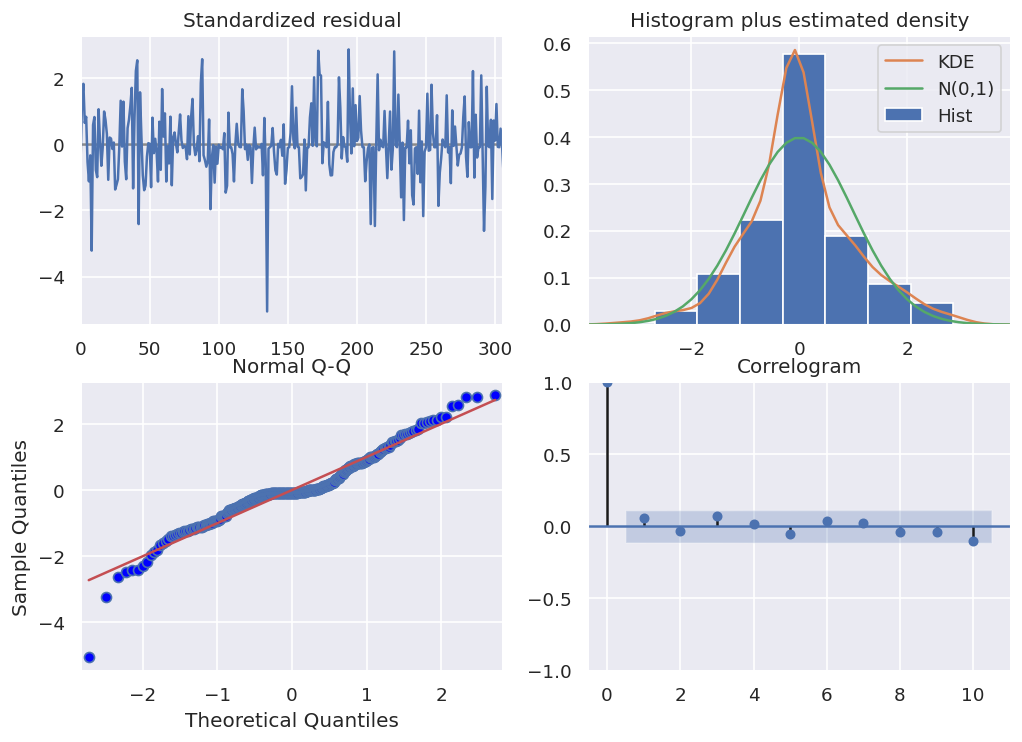

------------- Get Predictions --------------- 

------------- Model Evaluations --------------- 

MAPE :  2.2033105847303913
MAE  :  6.450290500564778
RMSE  :  7.8142148307673
R2 Score  :  0.30453820845776236
Durbin Watson Score :  0.18819779870021938


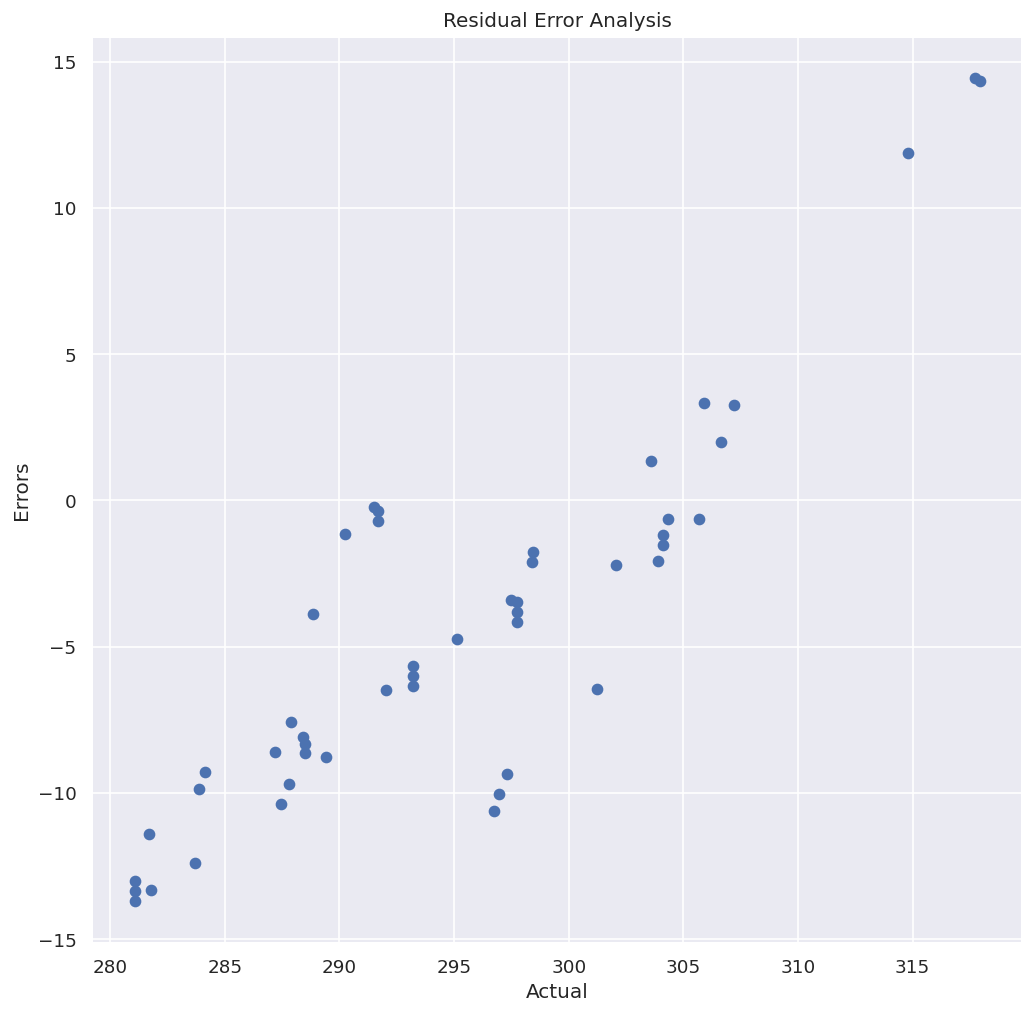

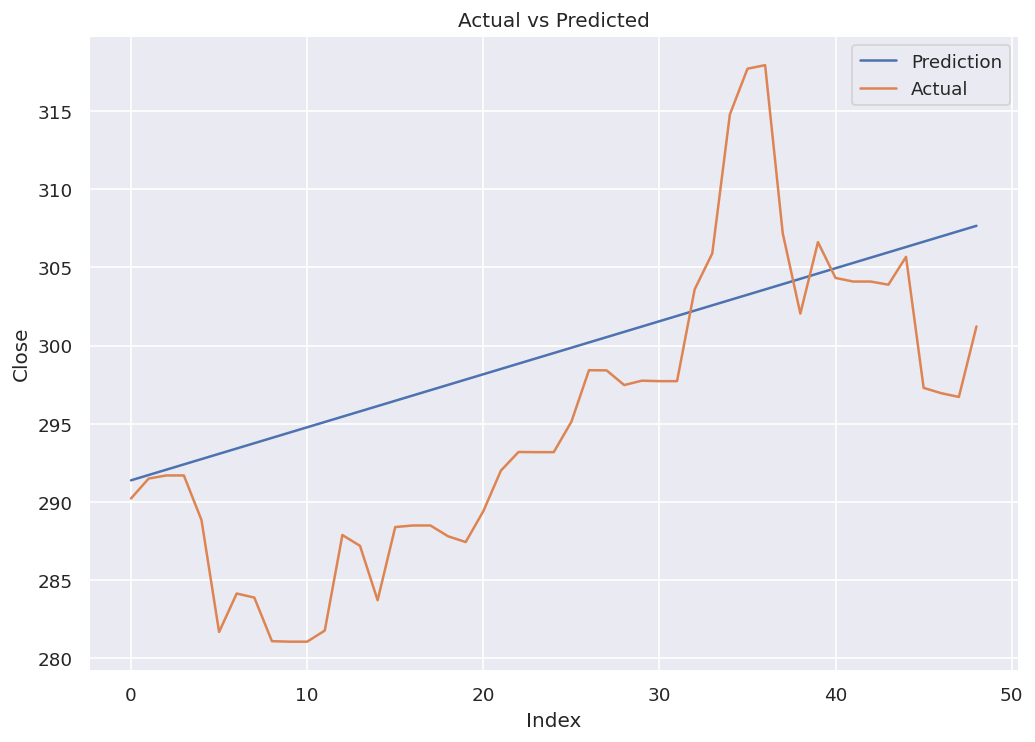

In [44]:
# Forecasting algorithm
input_ts_algo = 'auto_arima'
input_seasonality = 1
auto_arima = train_and_evaluate_model(input_ts_algo)

auto_sarima
------------- Auto SARIMA --------------- 

 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=1664.897, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=1665.861, Time=0.16 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=1665.530, Time=0.18 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=1666.061, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=1667.222, Time=0.46 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=1667.178, Time=0.38 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=1664.786, Time=0.24 sec
 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=1666.555, Time=0.35 sec
 ARIMA(0,1,0)(2,0,2)[5] intercept   : AIC=1668.062, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=1665.717, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=1666.554, Time=0.15 sec
 ARIMA(0,1,1)(0,0,2)[5] intercept   : AIC=1666.552, Time=0.31 sec
 ARIMA(0,1,1)(1,0,0)[5] intercept   : AIC=1666.764, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[5] intercept   : AIC=1668.007, Time=0.37 sec
 ARIMA(0,1,1)(1,0,2)

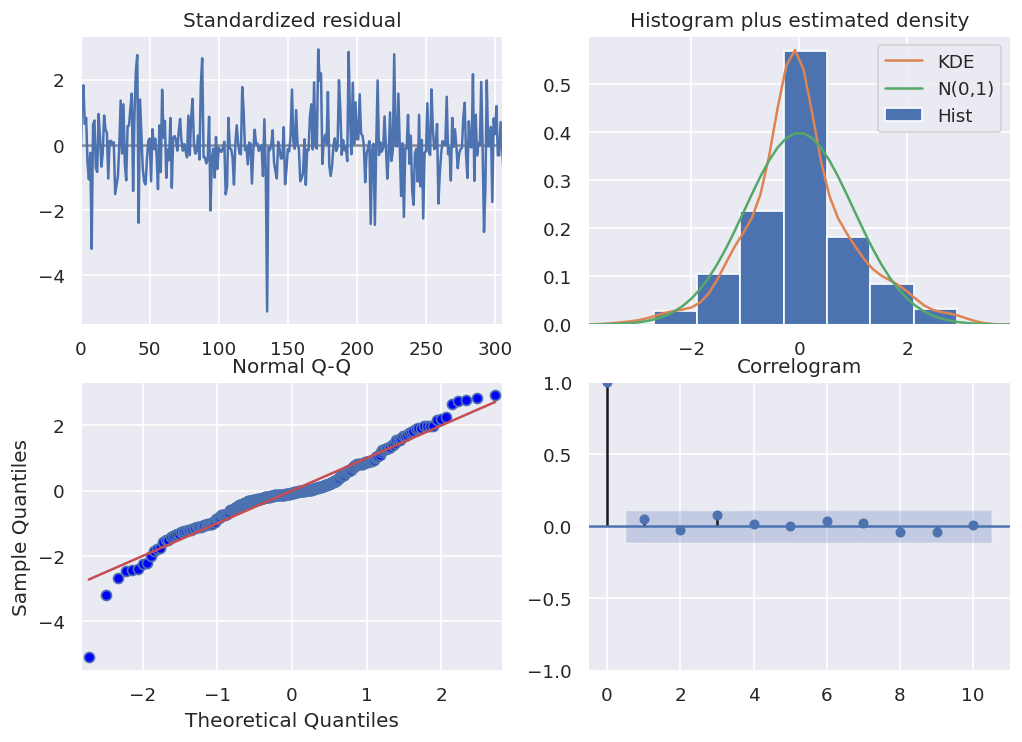

------------- Get Predictions --------------- 

------------- Model Evaluations --------------- 

MAPE :  2.160639368644089
MAE  :  6.327245120983126
RMSE  :  7.704300418314716
R2 Score  :  0.32396528232084043
Durbin Watson Score :  0.19288630356610398


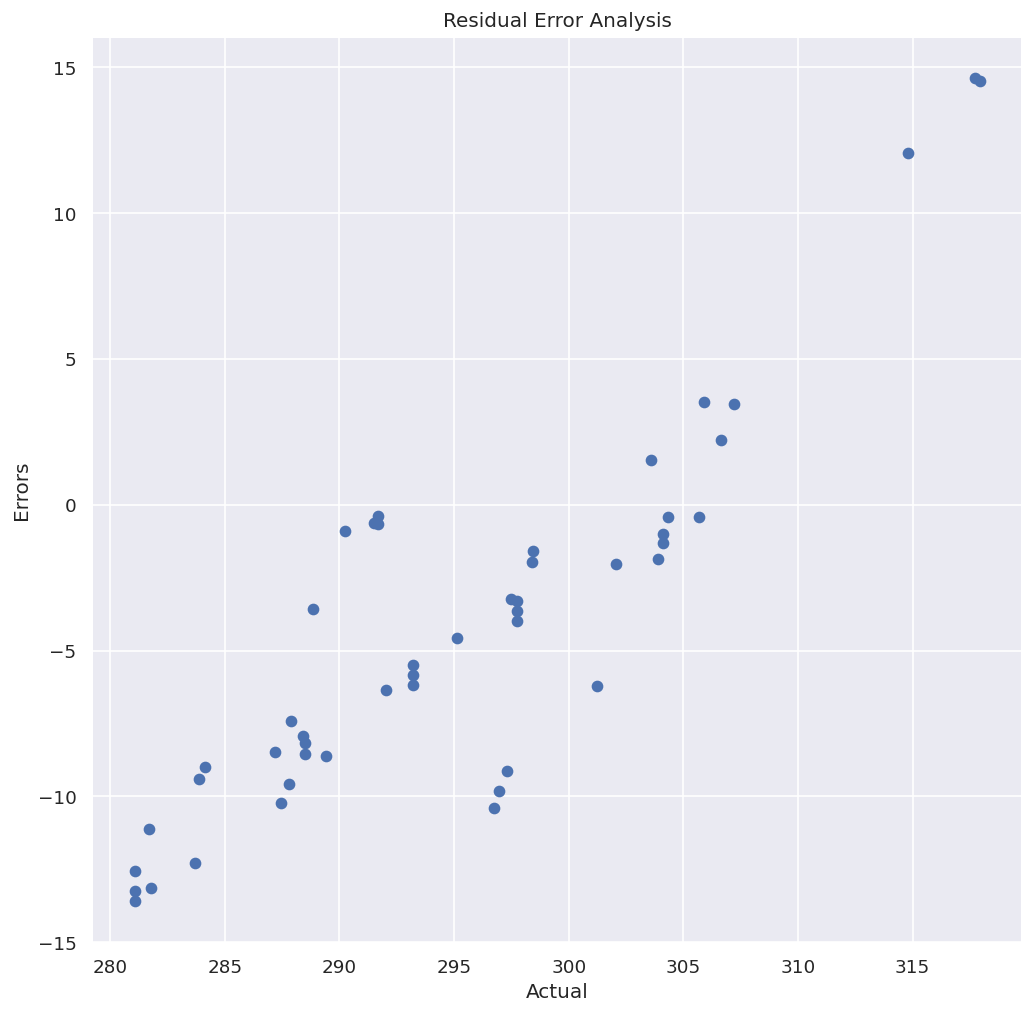

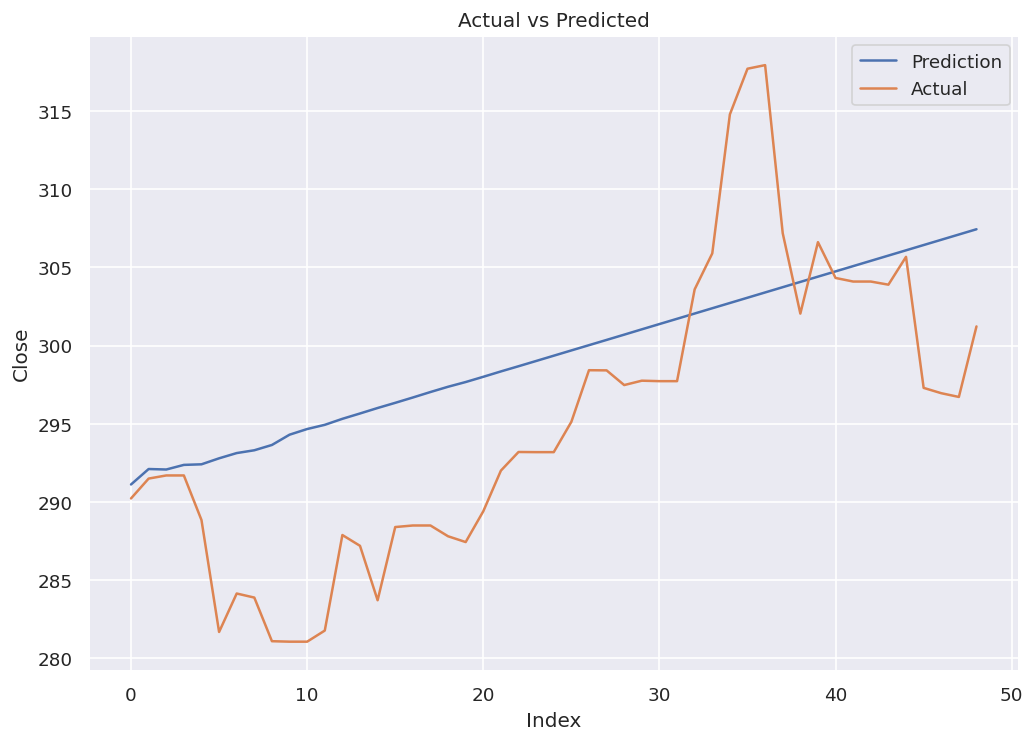

In [45]:
# Forecasting algorithm
input_ts_algo = 'auto_sarima'
input_seasonality = 5
auto_sarima = train_and_evaluate_model(input_ts_algo)

simple_exponential_smoothing
------------- Simple Exponential Smoothing --------------- 

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                  308
Model:             SimpleExpSmoothing   SSE                           8973.965
Optimized:                      False   AIC                           1042.571
Trend:                           None   BIC                           1050.031
Seasonal:                        None   AICC                          1042.703
Seasonal Periods:                None   Date:                 Fri, 28 May 2021
Box-Cox:                        False   Time:                         08:50:19
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3000000     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



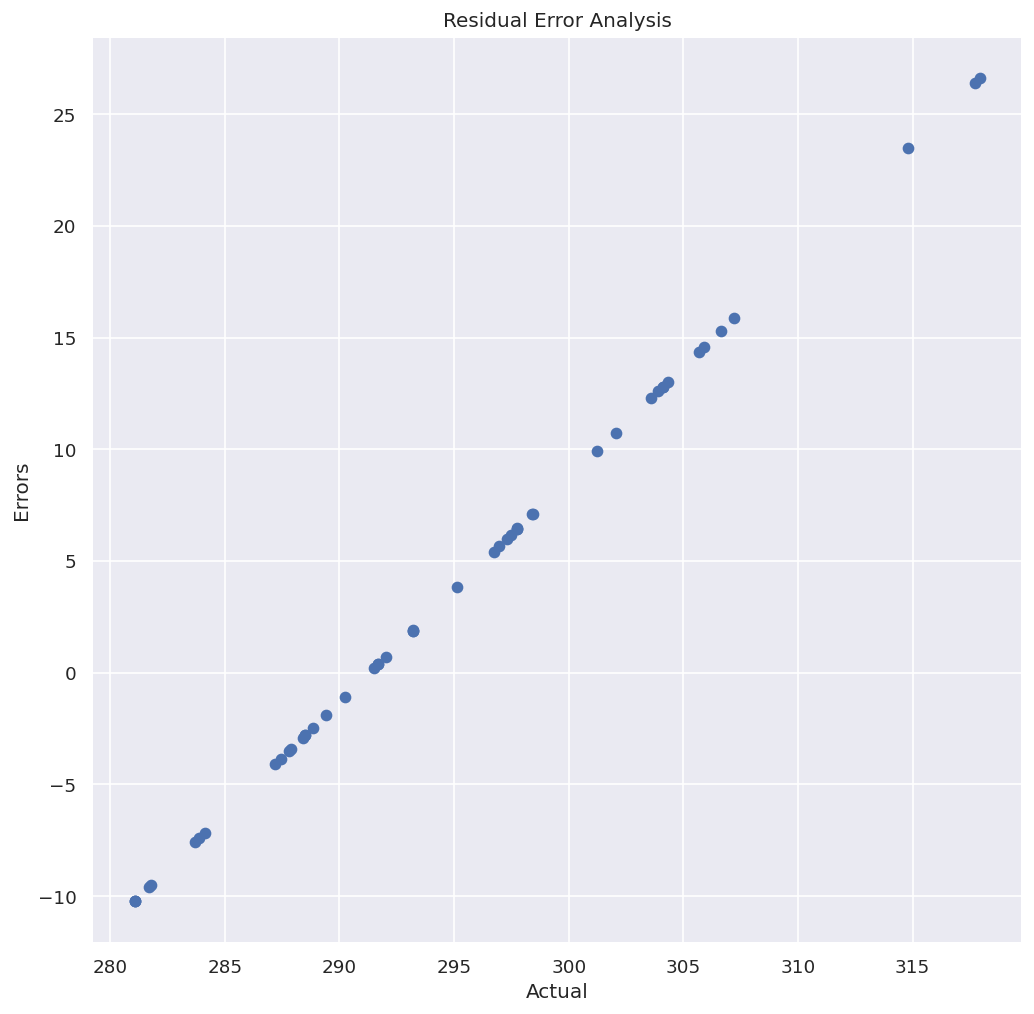

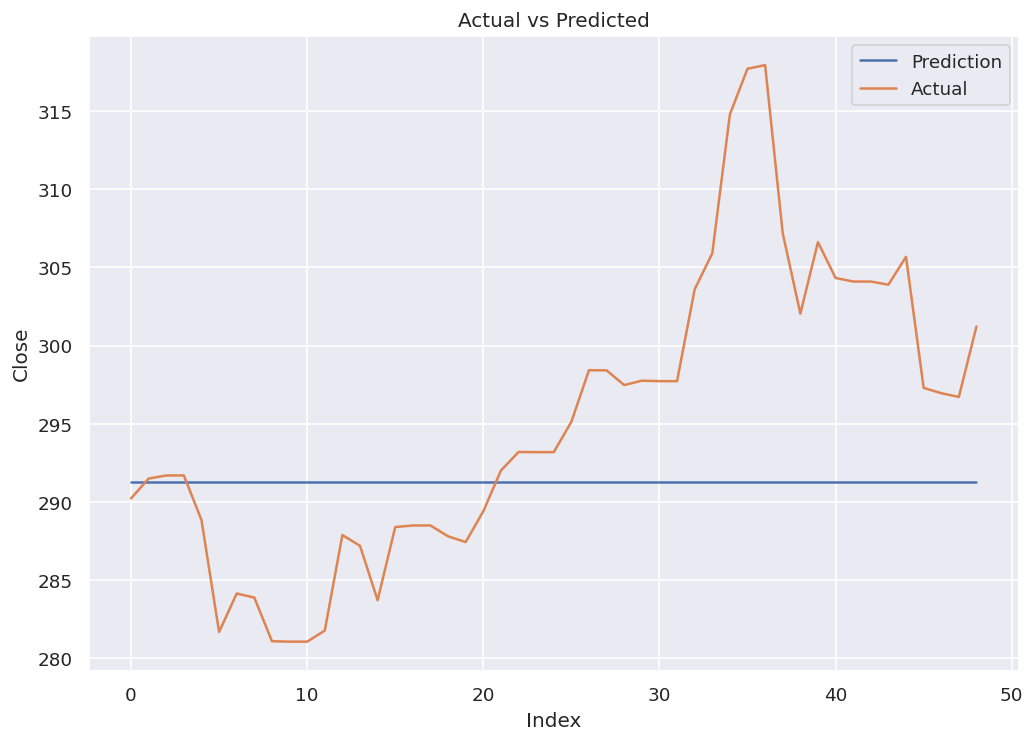

In [46]:
# Forecasting algorithm
input_ts_algo = 'simple_exponential_smoothing'
simple_exponential_smoothing = train_and_evaluate_model(input_ts_algo)

double_exponential_smoothing
------------- double_exponential_smoothing --------------- 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  308
Model:             ExponentialSmoothing   SSE                           4020.089
Optimized:                         True   AIC                            799.240
Trend:                         Additive   BIC                            814.160
Seasonal:                          None   AICC                           799.519
Seasonal Periods:                  None   Date:                 Fri, 28 May 2021
Box-Cox:                          False   Time:                         08:50:20
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level        

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



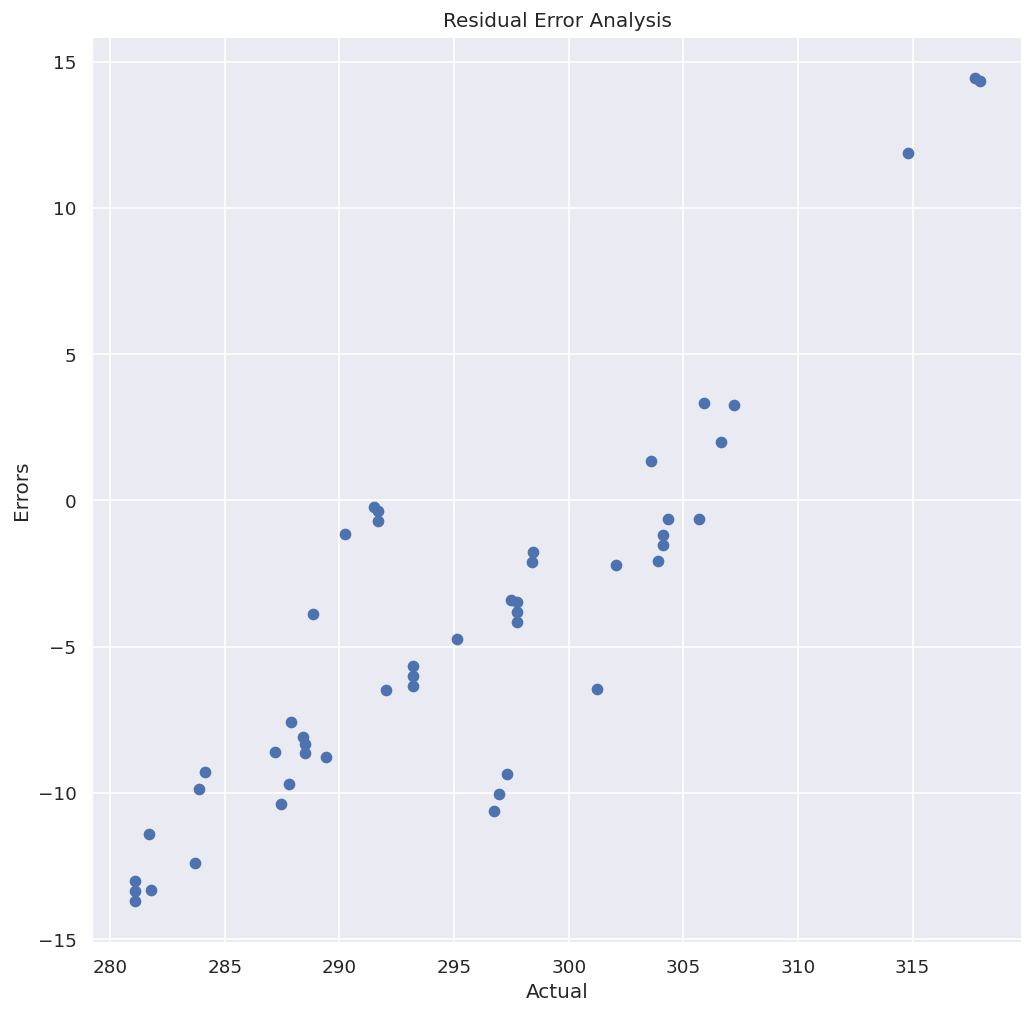

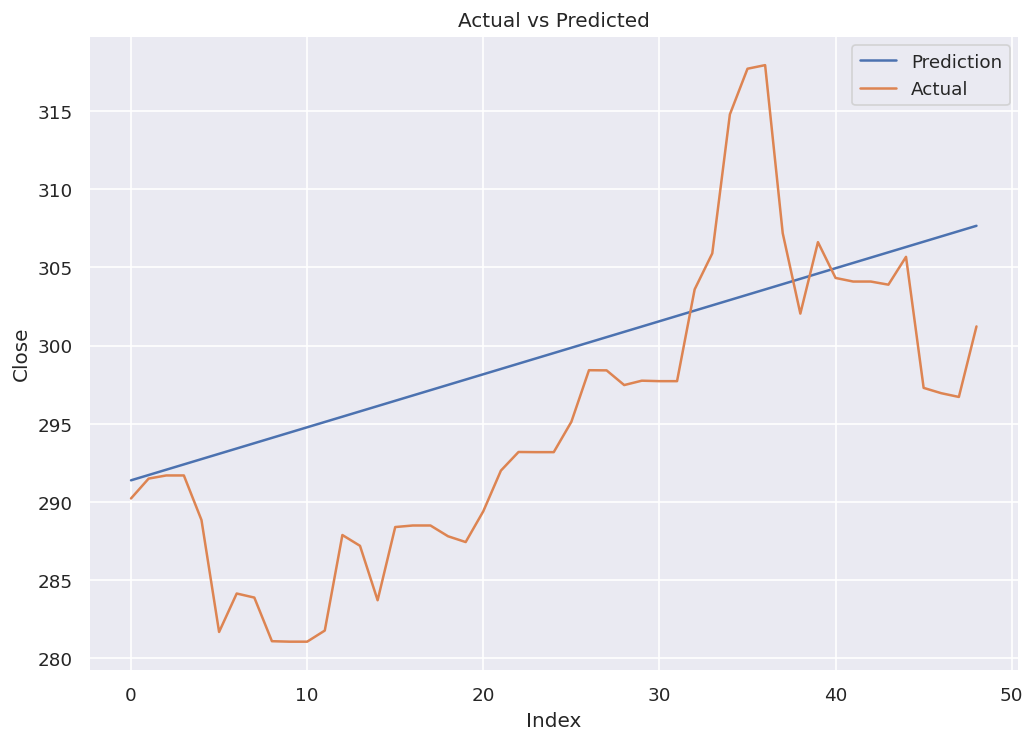

In [47]:
# Forecasting algorithm
input_ts_algo = 'double_exponential_smoothing'
double_exponential_smoothing = train_and_evaluate_model(input_ts_algo, type_='add')

holt_winters
------------- Holt Winters --------------- 



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  308
Model:             ExponentialSmoothing   SSE                           3957.192
Optimized:                         True   AIC                            804.383
Trend:                         Additive   BIC                            837.953
Seasonal:                      Additive   AICC                           805.274
Seasonal Periods:                     5   Date:                 Fri, 28 May 2021
Box-Cox:                          False   Time:                         08:50:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

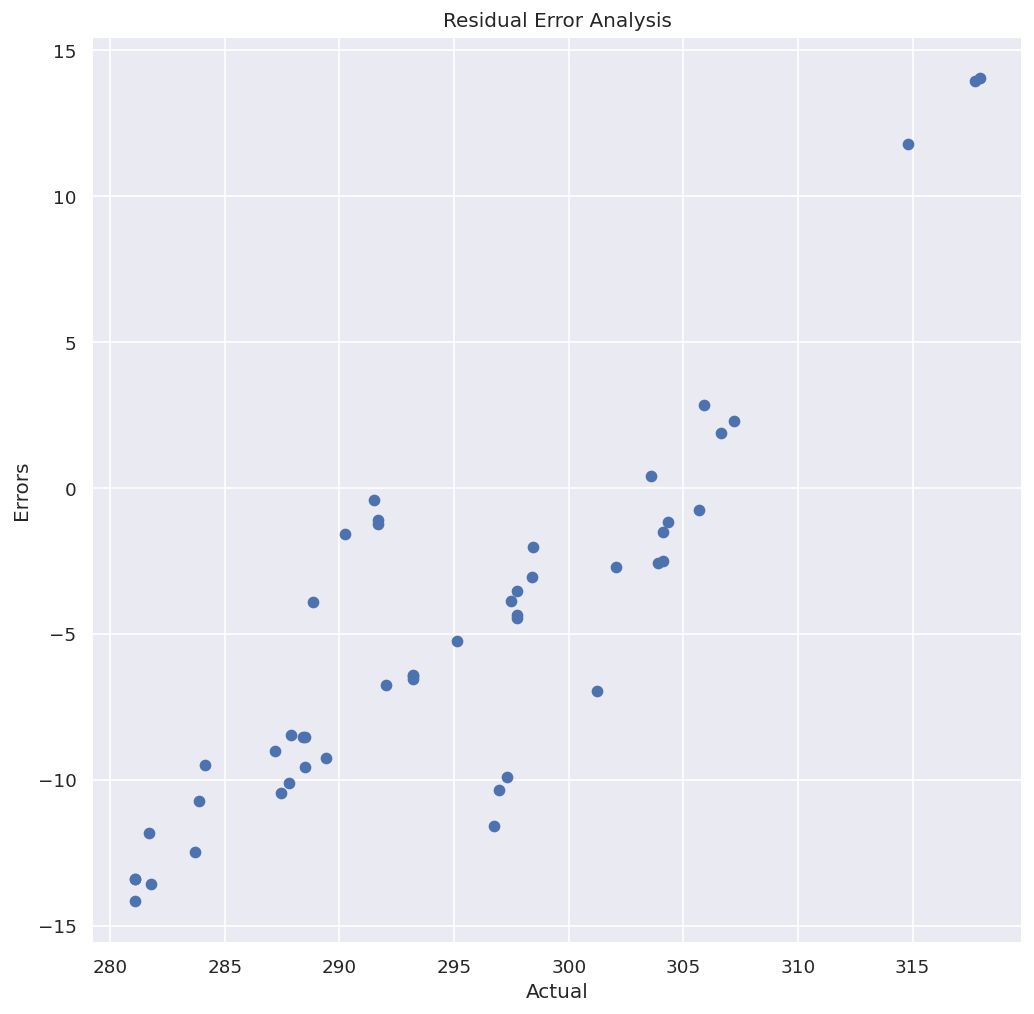

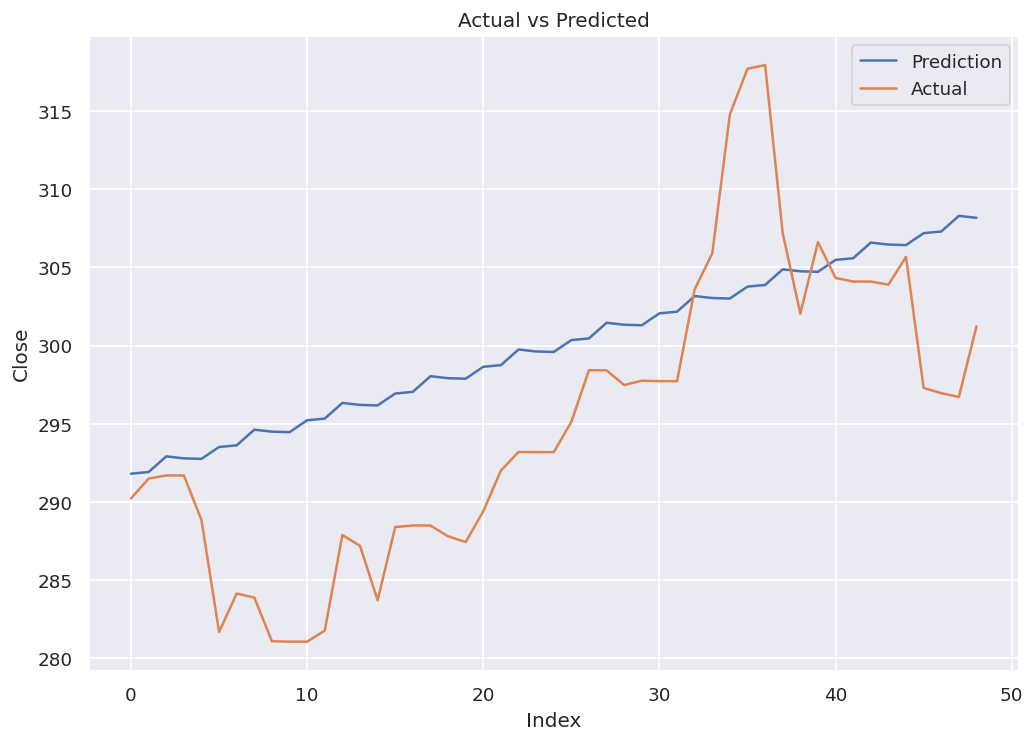

In [48]:
# Forecasting algorithm
input_seasonality = 5
input_ts_algo = 'holt_winters'
holt_winters = train_and_evaluate_model(input_ts_algo, type_='add')

### 4.11. Compare models

In [49]:
results = pd.DataFrame({
    'auto_arima': auto_arima,
    'auto_sarima': auto_sarima,
    'simple_exponential_smoothing': simple_exponential_smoothing,
    'double_exponential_smoothing': double_exponential_smoothing,
    'holt_winters': holt_winters
              })
results

auto_arima  auto_sarima  simple_exponential_smoothing  \
MAPE                   2.203311     2.160639                      2.651404   
RMSE                   7.814215     7.704300                     10.124945   
MAE                    6.450291     6.327245                      7.951059   
R2 Score               0.304538     0.323965                     -0.167583   
Durbin Watson Score    0.188198     0.192886                      0.112485   

                     double_exponential_smoothing  holt_winters  
MAPE                                     2.203311      2.307885  
RMSE                                     7.814215      8.065159  
MAE                                      6.450291      6.753499  
R2 Score                                 0.304538      0.259153  
Durbin Watson Score                      0.188198      0.183083

In [50]:
print(auto_arima)

{'MAPE': 2.2033105847303913, 'RMSE': 7.8142148307673, 'MAE': 6.450290500564778, 'R2 Score': 0.30453820845776236, 'Durbin Watson Score': 0.18819779870021938}


__Step's coclusion__

Analysis of 5 classic models for analyzing time data for two months shows that the models generally was able with capturing the main trend, but they absolutely cannot capture fluctuations during the selected two months.

I suppose that this is due to the fact that classical models try to decompose the time series into trend, season and errors, and since all the charts show that seasonality is not visible in the data, the model was able to restore only the trend.

In any case, we got the border for comparison, then other methods will be applied.

## 5.0 Classic ML with feature engineering (normal or tsfresh)

### 5.1 Usual linear regression with default feature engineering

In [51]:
scaler = StandardScaler()

# for time-series cross-validation set 5 folds 
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [52]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())
    
def prepareData(series, lag_start, lag_end, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    

    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y)

    return X_train, X_test, y_train, y_test

In [53]:
def timeseries_train_test_split(X, y):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    start_index = df[df[input_date_variable] == '2020-04-01'].index[0]
    test_index = df[df[input_date_variable] == '2021-04-01'].index[0]

    X_train = X.loc['2020-04-01':'2021-04-01']
    y_train = y.loc['2020-04-01':'2021-04-01']
    X_test = X.loc['2021-04-01':]
    y_test = y.loc['2021-04-01':]
    
    return X_train, X_test, y_train, y_test

In [54]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

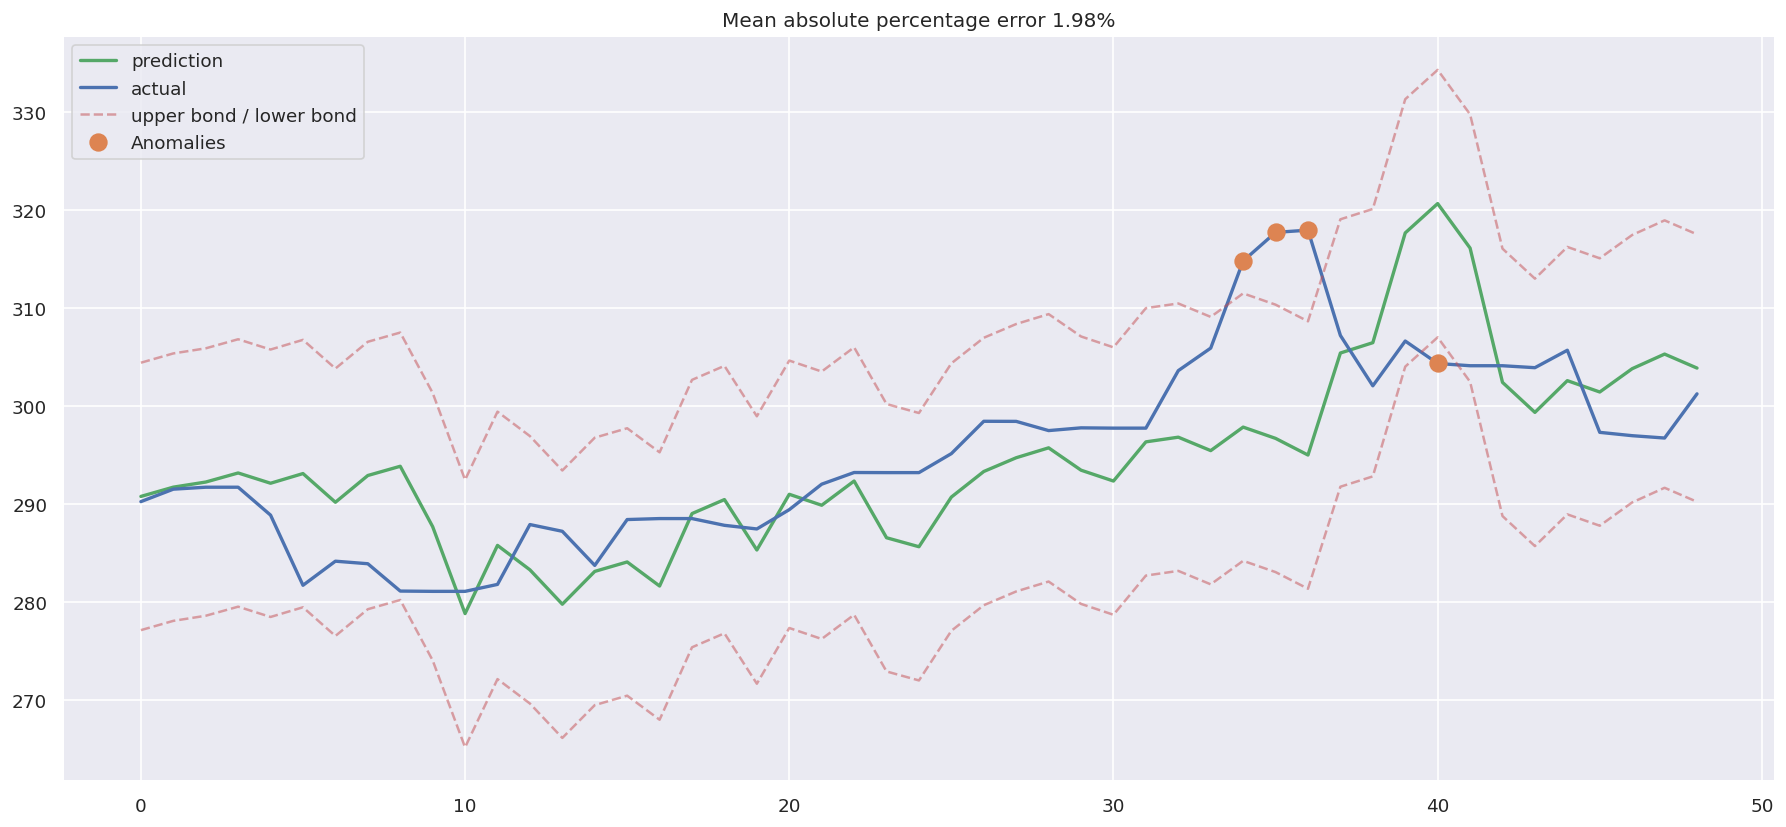

In [55]:
data = df.set_index(df[input_date_variable])[input_target_variable]
X_train, X_test, y_train, y_test = prepareData(data, lag_start=5, lag_end=30, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)

------------- Model Evaluations --------------- 

MAPE :  1.9633818384690156
MAE  :  5.865084492920938
RMSE  :  7.836058388954235
R2 Score  :  0.30064463933681795
Durbin Watson Score :  0.5284572268838186


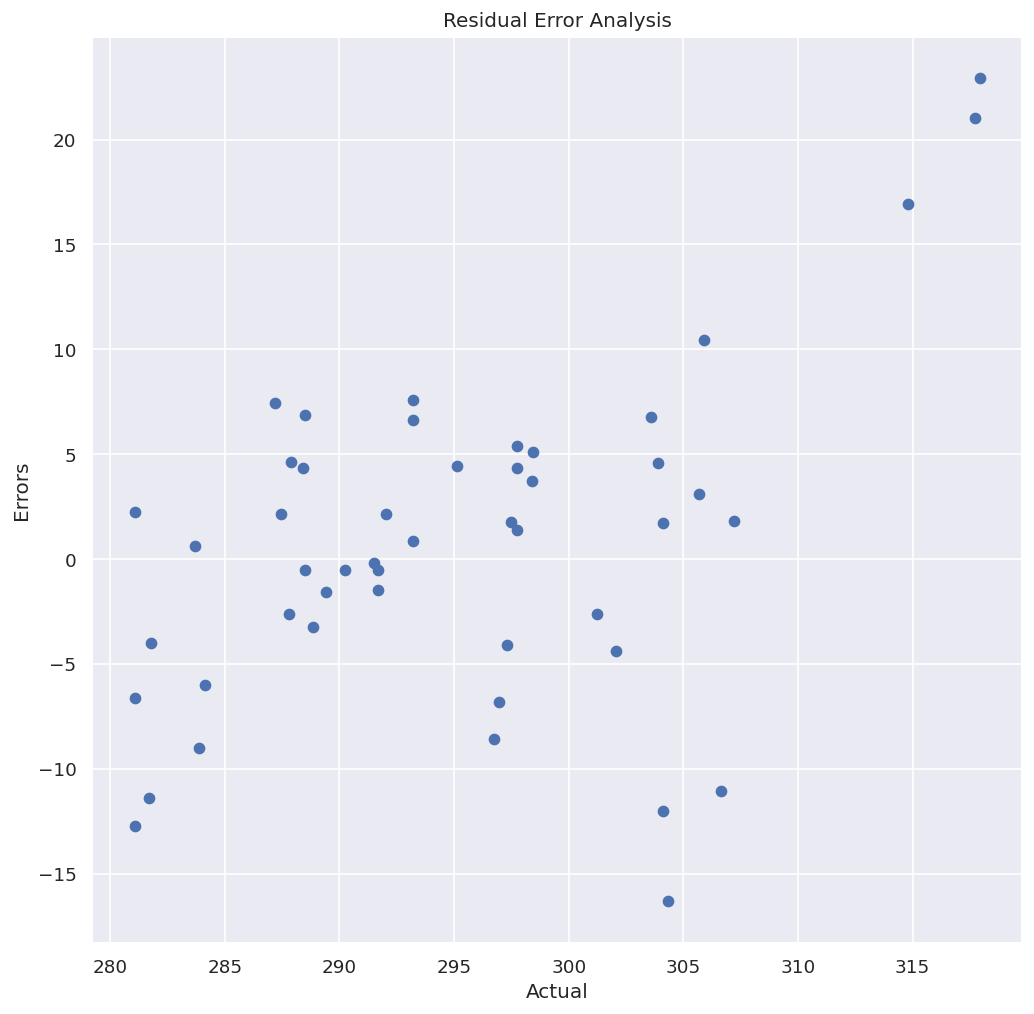

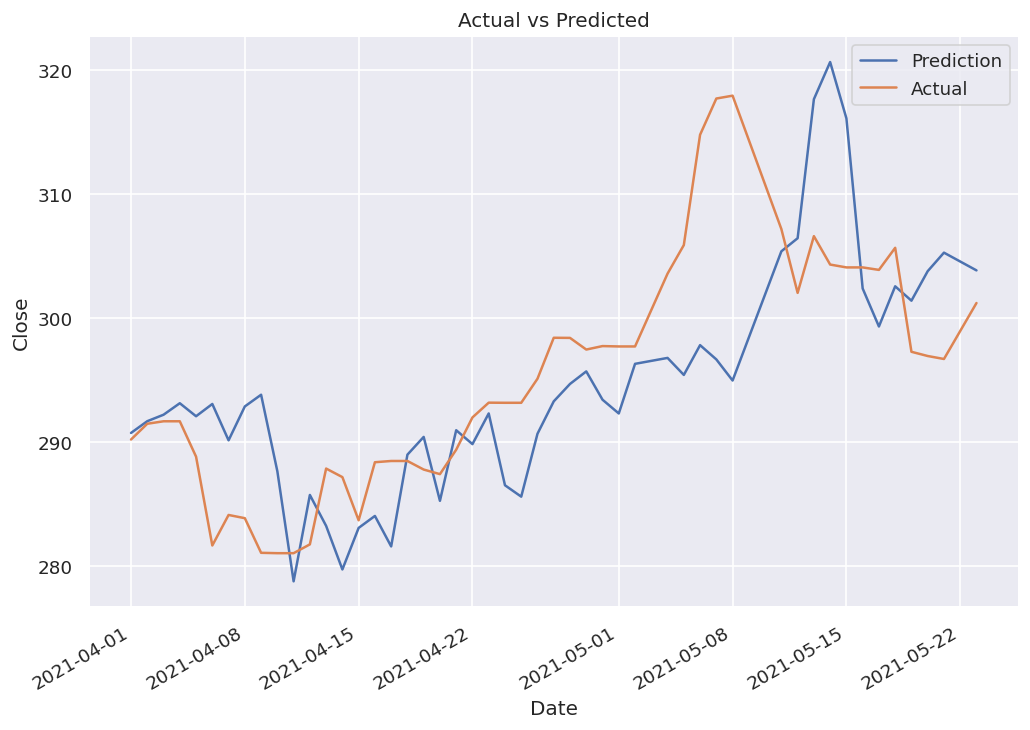

In [56]:
predictions = pd.Series(lr.predict(X_test_scaled), index=y_test.index)
actuals = pd.Series(y_test, index=y_test.index)
lr_results = evaluate_model(actuals, predictions, input_target_variable = input_target_variable)

In [57]:
results['Linear regression with feature engineering'] = pd.Series(lr_results)
results

auto_arima  auto_sarima  simple_exponential_smoothing  \
MAPE                   2.203311     2.160639                      2.651404   
RMSE                   7.814215     7.704300                     10.124945   
MAE                    6.450291     6.327245                      7.951059   
R2 Score               0.304538     0.323965                     -0.167583   
Durbin Watson Score    0.188198     0.192886                      0.112485   

                     double_exponential_smoothing  holt_winters  \
MAPE                                     2.203311      2.307885   
RMSE                                     7.814215      8.065159   
MAE                                      6.450291      6.753499   
R2 Score                                 0.304538      0.259153   
Durbin Watson Score                      0.188198      0.183083   

                     Linear regression with feature engineering  
MAPE                                                   1.963382  
RMSE                                                   7.836058  
MAE                                                    5.865084  
R2 Score                                               0.300645  
Durbin Watson Score                                    0.528457

__Step's coclusion__

Linear regression with feature engeneering gives much better performance.

### 5.3 tsfresh feature engeneering

In [58]:
# is needed for tsfresh 
df['Symbols'] = 'Sber'

In [59]:
df_rolled = roll_time_series(df[['Date', 'Close', 'Symbols']], column_id="Symbols", column_sort="Date",
                             max_timeshift=20, min_timeshift=5)

/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:456: UserWarning:

Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.

Rolling: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


In [60]:
#initially we have 826 rows in the dataset
len(df)

826

In [61]:
#after rolling it has 825 (as we havw min_timeshift=1)
df_rolled["id"].nunique()

821

In [62]:
X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="Date", column_value="Close", 
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 5/5 [00:47<00:00,  9.56s/it]


In [63]:
X.head()

Close__variance_larger_than_standard_deviation  \
Sber 2018-05-30                                             0.0   
     2018-05-31                                             1.0   
     2018-06-01                                             1.0   
     2018-06-04                                             1.0   
     2018-06-05                                             1.0   

                 Close__has_duplicate_max  Close__has_duplicate_min  \
Sber 2018-05-30                       0.0                       0.0   
     2018-05-31                       0.0                       0.0   
     2018-06-01                       0.0                       0.0   
     2018-06-04                       0.0                       0.0   
     2018-06-05                       0.0                       0.0   

                 Close__has_duplicate  Close__sum_values  Close__abs_energy  \
Sber 2018-05-30                   0.0            1323.92        292132.6702   
     2018-05-31                   0.0            1546.28        341576.6398   
     2018-06-01                   1.0            1766.28        389976.6398   
     2018-06-04                   1.0            1986.28        438376.6398   
     2018-06-05                   1.0            2201.84        484842.7534   

                 Close__mean_abs_change  Close__mean_change  \
Sber 2018-05-30                1.566000            0.002000   
     2018-05-31                1.530000            0.226667   
     2018-06-01                1.648571           -0.142857   
     2018-06-04                1.442500           -0.125000   
     2018-06-05                1.775556           -0.604444   

                 Close__mean_second_derivative_central  Close__median  \
Sber 2018-05-30                               0.125000         220.95   
     2018-05-31                               0.034000         221.00   
     2018-06-01                              -0.280833         220.95   
     2018-06-04                              -0.072143         220.90   
     2018-06-05                              -0.340625         220.45   

                 Close__mean  Close__length  Close__standard_deviation  \
Sber 2018-05-30   220.653333            6.0                   0.940668   
     2018-05-31   220.897143            7.0                   1.055986   
     2018-06-01   220.785000            8.0                   1.031383   
     2018-06-04   220.697778            9.0                   1.003204   
     2018-06-05   220.184000           10.0                   1.811487   

                 Close__variation_coefficient  Close__variance  \
Sber 2018-05-30                      0.004263         0.884856   
     2018-05-31                      0.004780         1.115106   
     2018-06-01                      0.004671         1.063750   
     2018-06-04                      0.004546         1.006417   
     2018-06-05                      0.008227         3.281484   

                 Close__skewness  Close__kurtosis  Close__root_mean_square  \
Sber 2018-05-30        -0.602992         0.626730               220.655338   
     2018-05-31        -0.477873         0.036010               220.899667   
     2018-06-01        -0.126012        -0.417745               220.787409   
     2018-06-04         0.134143        -0.468002               220.700058   
     2018-06-05        -1.649407         3.768340               220.191452   

                 Close__absolute_sum_of_changes  \
Sber 2018-05-30                            7.83   
     2018-05-31                            9.18   
     2018-06-01                           11.54   
     2018-06-04                           11.54   
     2018-06-05                           15.98   

                 Close__longest_strike_below_mean  \
Sber 2018-05-30                               1.0   
     2018-05-31                               1.0   
     2018-06-01                               1.0   
     2018-06-04                               2.0   
     2018-0

In [64]:
# drop first level of index
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"

In [65]:
# our target is the next day price
y = df.set_index('Date').Close.shift(-1)

In [66]:
X_train = X["2020-04-01":'2021-04-01']
X_test = X["2021-04-01":'2021-05-22']

y_train = y["2020-04-01":'2021-04-01']
y_test = y["2021-04-01":'2021-05-22']

In [67]:
X_train_selected = select_features(X_train, y_train)

In [68]:
len(X_train_selected.columns)

205

In [69]:
ada = LinearRegression()

ada.fit(X_train_selected, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

------------- Model Evaluations --------------- 

MAPE :  1.6892805974371403
MAE  :  4.991431136478561
RMSE  :  6.2068355960009685
R2 Score  :  0.567702839350481
Durbin Watson Score :  0.6032019539156935


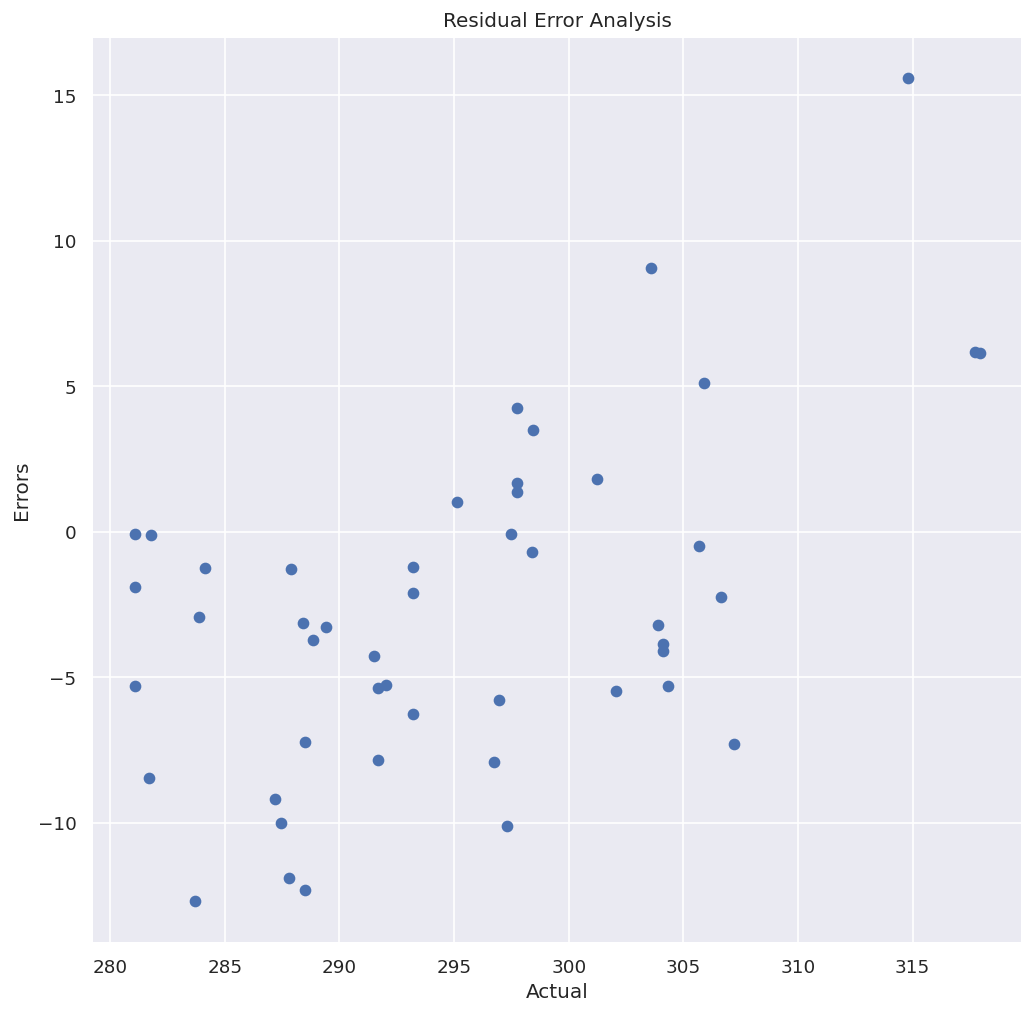

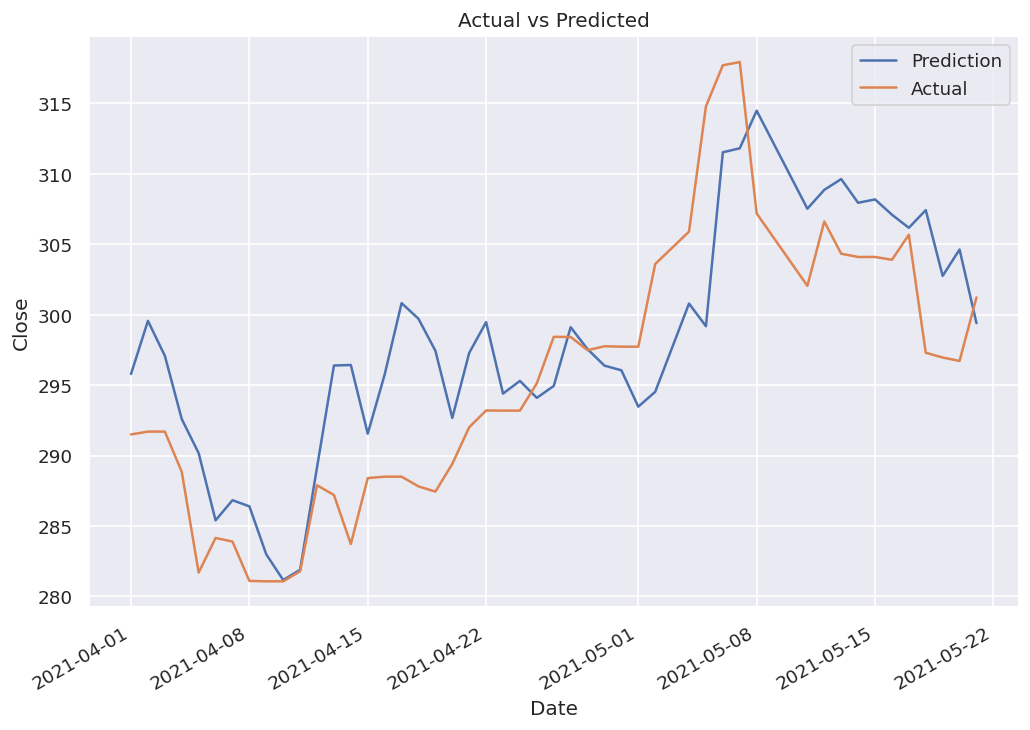

In [70]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.Series(ada.predict(X_test_selected), index=X_test_selected.index)

actuals = pd.Series(y_test, index=y_test.index)
tsfresh_results = evaluate_model(actuals, y_pred, input_target_variable = input_target_variable)

In [71]:
results['Linear regression with tsfresh'] = pd.Series(tsfresh_results)
results

auto_arima  auto_sarima  simple_exponential_smoothing  \
MAPE                   2.203311     2.160639                      2.651404   
RMSE                   7.814215     7.704300                     10.124945   
MAE                    6.450291     6.327245                      7.951059   
R2 Score               0.304538     0.323965                     -0.167583   
Durbin Watson Score    0.188198     0.192886                      0.112485   

                     double_exponential_smoothing  holt_winters  \
MAPE                                     2.203311      2.307885   
RMSE                                     7.814215      8.065159   
MAE                                      6.450291      6.753499   
R2 Score                                 0.304538      0.259153   
Durbin Watson Score                      0.188198      0.183083   

                     Linear regression with feature engineering  \
MAPE                                                   1.963382   
RMSE                                                   7.836058   
MAE                                                    5.865084   
R2 Score                                               0.300645   
Durbin Watson Score                                    0.528457   

                     Linear regression with tsfresh  
MAPE                                       1.689281  
RMSE                                       6.206836  
MAE                                        4.991431  
R2 Score                                   0.567703  
Durbin Watson Score                        0.603202

__Step's coclusion__

Tsfresh performe worse than more simple feature engeneering: I think that happens because of the overfitting with all added columns in tsfresh

## 6.0 Prophet library

Prophet assumptions:
* hourly, daily, or weekly observations with at least a few months (preferably a year) of history
* strong multiple “human-scale” seasonalities: day of week and time of year
important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
* a reasonable number of missing observations or large outliers
* historical trend changes, for instance due to product launches or logging changes
* trends that are non-linear growth curves, where a trend hits a natural limit or saturates

At its core, the Prophet procedure is an additive regression model with four main components:

* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.

**Trend**

The Prophet library implements two possible trend models for $g(t)$.

The first one is called *Nonlinear, Saturating Growth*. It is represented in the form of the [logistic growth model](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$

where:
* $C$ is the carrying capacity (that is the curve's maximum value).
* $k$ is the growth rate (which represents "the steepness" of the curve).
* $m$ is an offset parameter.

This logistic equation allows modelling non-linear growth with saturation, that is when the growth rate of a value decreases with its growth. One of the typical examples would be representing the growth of the audience of an application or a website.

Actually, $C$ and $k$ are not necessarily constants and may vary over time. Prophet supports both automatic and manual tuning of their variability. The library can itself choose optimal points of trend changes by fitting the supplied historical data. 

Also, Prophet allows analysts to manually set changepoints of the growth rate and capacity values at different points in time. For instance, analysts may have insights about dates of past releases that prominently influenced some key product indicators.

The second trend model is a simple *Piecewise Linear Model* with a constant rate of growth. It is best suited for problems without saturating growth.

Seasonality

The seasonal component $s(t)$ provides a flexible model of periodic changes due to weekly and yearly seasonality.

Weekly seasonal data is modeled with dummy variables. Six new variables are added: `monday`, `tuesday`, `wednesday`, `thursday`, `friday`, `saturday`, which take values 0 or 1 depending on the day of the week. The feature `sunday` is not added because it would be a linear combination of the other days of the week, and this fact would have an adverse effect on the model.

Yearly seasonality model in Prophet relies on Fourier series.

Since [version 0.2](https://github.com/facebook/prophet) you can also use *sub-daily time series* and make *sub-daily forecasts* as well as employ the new *daily seasonality* feature.

Holidays and Events

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.

To utilize this feature, the analyst needs to provide a custom list of events.

Error

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.

In [72]:
df_train = df.set_index(input_date_variable)["2020-04-01":'2021-03-31'].reset_index()
df_test = df.set_index(input_date_variable)["2021-04-01":'2021-05-22'].reset_index()

In [73]:
prophet_example = df_train[[input_date_variable, input_target_variable]]
prophet_example.columns = ['ds', 'y']
prophet_example.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [74]:
# try with default hyper-parameters
m = Prophet()
m.fit(prophet_example)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
future = m.make_future_dataframe(periods=len(df_test)*2)

In [76]:
future.tail()

ds
400 2021-07-01
401 2021-07-02
402 2021-07-03
403 2021-07-04
404 2021-07-05

In [77]:
forecast = m.predict(future)
predictions = forecast[forecast['ds'].isin(X_test.index)].set_index('ds')['yhat']

------------- Model Evaluations --------------- 

MAPE :  2.1403333414590593
MAE  :  6.450427669044973
RMSE  :  8.619235193260385
R2 Score  :  0.16635843204967782
Durbin Watson Score :  0.16749973413581717


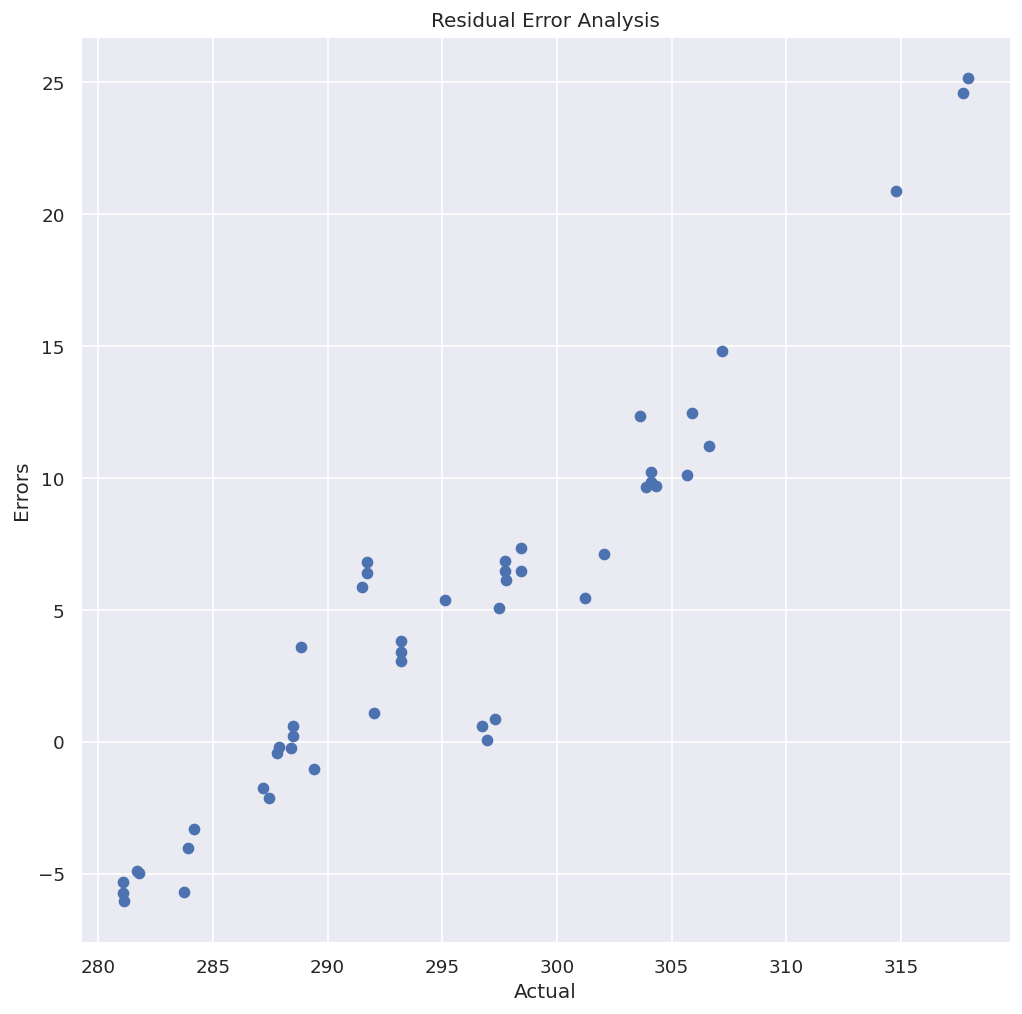

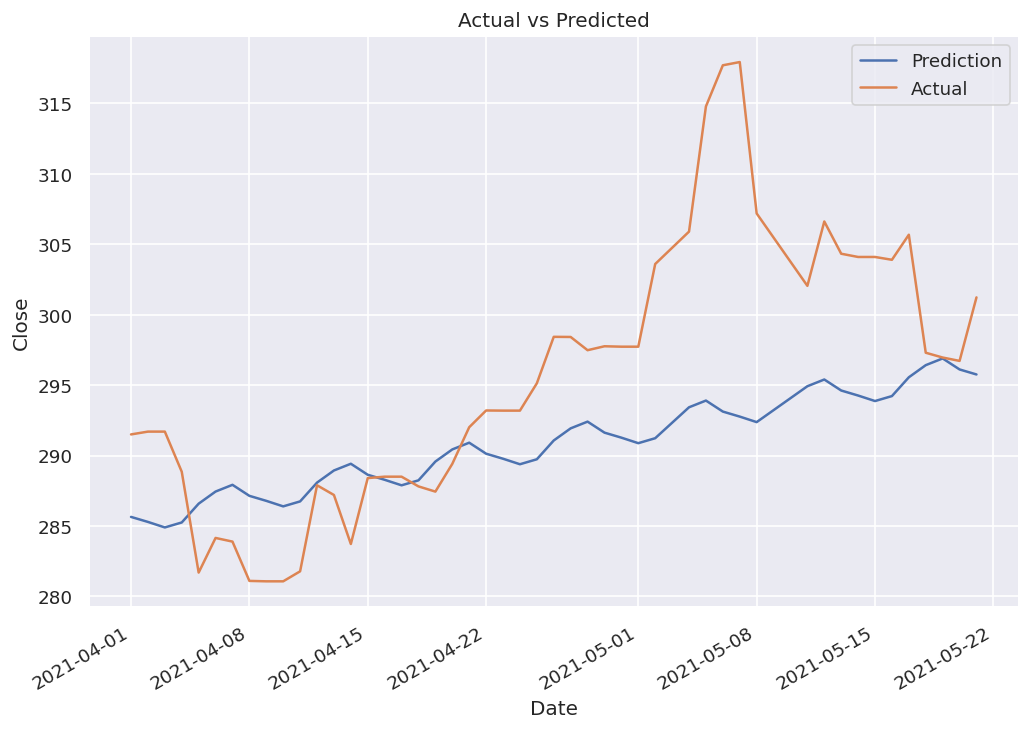

In [78]:
actuals = pd.Series(y_test, index=y_test.index)
prophet_results = evaluate_model(actuals, predictions, input_target_variable = input_target_variable)

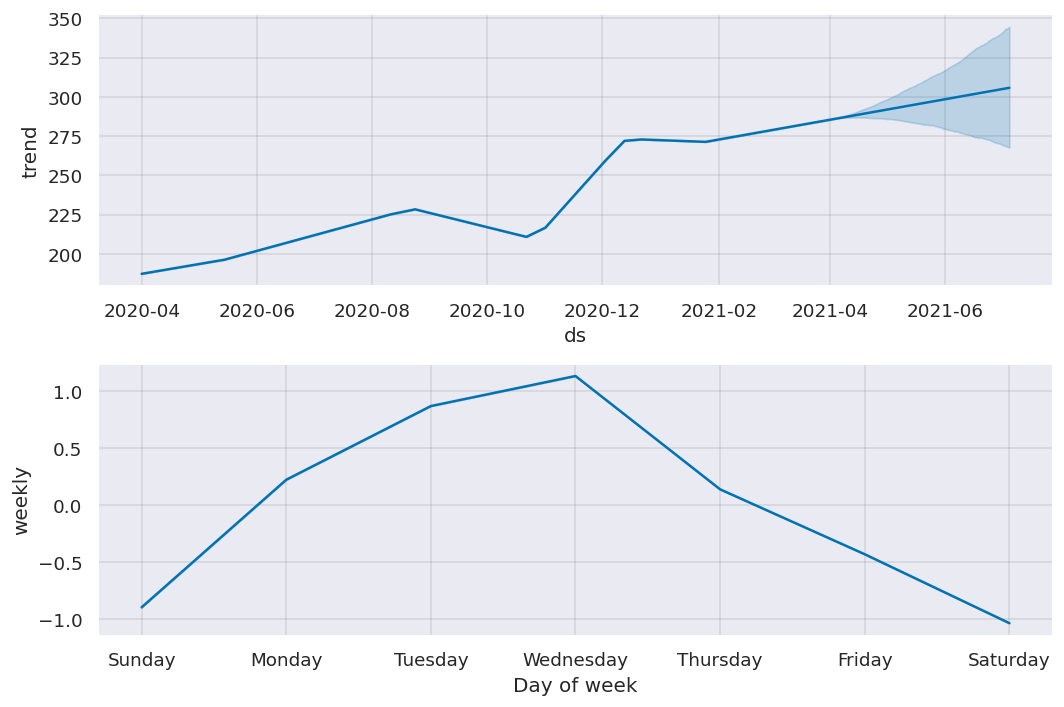

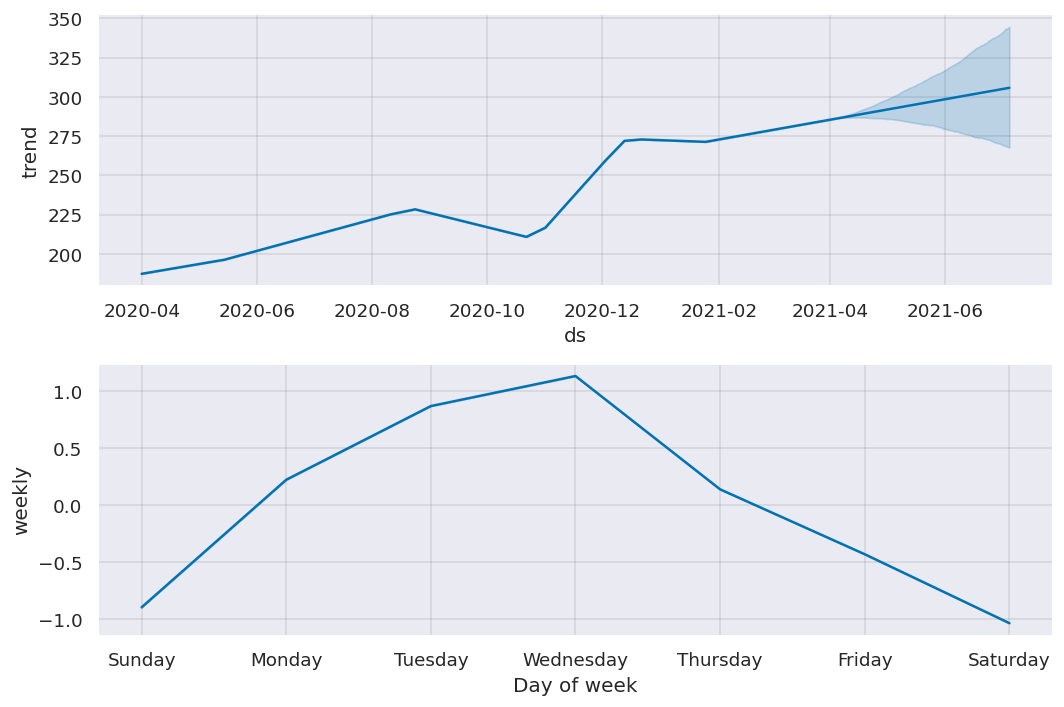

In [79]:
m.plot_components(forecast)

In [80]:
# ref: https://nbviewer.jupyter.org/github/ryankarlos/prophet/blob/9e6d9548d1caca27af3367819bab10a65da10392/notebooks/diagnostics.ipynb#Hyperparameter-Optimisation
from itertools import product
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics


def create_param_combinations(**param_dict):
    param_iter = product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m = Prophet(**param_dict)
    m.add_country_holidays(country_name='US')
    m.fit(history_df)
    df_cv = cross_validation(m, initial='90 days', period='30 days', horizon = '90 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

param_grid = {  
                'changepoint_prior_scale': [0.05, 0.5, 5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear']
              }

metrics = ['horizon', 'rmse', 'mape', 'params'] 

results_ = []


params_df = create_param_combinations(**param_grid)
for param in params_df.values[:30]:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(prophet_example,  metrics, param_dict)
    results_.append(cv_df)
results_df = pd.concat(results_).reset_index(drop=True)
best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-07-04 00:00:00 and 2020-12-31 00:00:00




 The best param combination is {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'growth': 'linear'}


horizon     rmse      mape  \
0  50 days  46.8737  0.153295   
1  50 days  46.7417  0.152116   
2  50 days  46.6567    0.1523   
3  50 days  46.7918  0.153097   
4  50 days  46.5053  0.151275   
5  50 days  46.7322  0.151994   
6  50 days  109.763   0.27108   
7  50 days  46.1649  0.149439   
8  50 days   110.15  0.272174   
9  50 days  46.7577  0.152077   
10 50 days  110.553  0.273019   
11 50 days  46.7715  0.153048   
12 50 days  164.248  0.334452   
13 50 days  77.6853  0.217227   
14 50 days  163.599  0.335231   
15 50 days  77.8118  0.217895   
16 50 days  163.607  0.335448   
17 50 days  77.9685  0.218845   
18 50 days  46.5871  0.155096   
19 50 days  45.1491  0.149496   
20 50 days  45.4669  0.151394   
21 50 days  45.6861  0.152307   
22 50 days  44.1452  0.146022   
23 50 days  44.4753  0.146662   
24 50 days  109.517  0.264932   
25 50 days  44.1265  0.144282   
26 50 days  110.255  0.268939   
27 50 days  45.3566  0.149254   
28 50 days   117.17   0.28019   
29 50 days  44.0169  0.145506   

                                               params  
0   {'changepoint_prior_scale': 0.05, 'changepoint...  
1   {'changepoint_prior_scale': 0.05, 'changepoint...  
2   {'changepoint_prior_scale': 0.05, 'changepoint...  
3   {'changepoint_prior_scale': 0.05, 'changepoint...  
4   {'changepoint_prior_scale': 0.05, 'changepoint...  
5   {'changepoint_prior_scale': 0.05, 'changepoint...  
6   {'changepoint_prior_scale': 0.05, 'changepoint...  
7   {'changepoint_prior_scale': 0.05, 'changepoint...  
8   {'changepoint_prior_scale': 0.05, 'changepoint...  
9   {'changepoint_prior_scale': 0.05, 'changepoint...  
10  {'changepoint_prior_scale': 0.05, 'changepoint...  
11  {'changepoint_prior_scale': 0.05, 'changepoint...  
12  {'changepoint_prior_scale': 0.05, 'changepoint...  
13  {'changepoint_prior_scale': 0.05, 'changepoint...  
14  {'changepoint_prior_scale': 0.05, 'changepoint...  
15  {'changepoint_prior_scale': 0.05, 'changepoint...  
16  {'changepoint_prior_scale': 0.05, 'changepoint...  
17  {'changepoint_prior_scale': 0.05, 'changepoint...  
18  {'changepoint_prior_scale': 0.05, 'changepoint...  
19  {'changepoint_prior_scale': 0.05, 'changepoint...  
20  {'changepoint_prior_scale': 0.05, 'changepoint...  
21  {'changepoint_prior_scale': 0.05, 'changepoint...  
22  {'changepoint_prior_scale': 0.05, 'changepoint...  
23  {'changepoint_prior_scale': 0.05, 'changepoint...  
24  {'changepoint_prior_scale': 0.05, 'changepoint...  
25  {'changepoint_prior_scale': 0.05, 'changepoint...  
26  {'changepoint_prior_scale': 0.05, 'changepoint...  
27  {'changepoint_prior_scale': 0.05, 'changepoint...  
28  {'changepoint_prior_scale': 0.05, 'changepoint...  
29  {'changepoint_prior_scale': 0.05, 'changepoint...

In [81]:
m = Prophet(**{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'growth': 'linear'})
m.fit(prophet_example)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [82]:
future = m.make_future_dataframe(periods=len(df_test)*2)

In [83]:
forecast = m.predict(future)
predictions = forecast[forecast['ds'].isin(X_test.index)].set_index('ds')['yhat']

------------- Model Evaluations --------------- 

MAPE :  1.9258533825132418
MAE  :  5.660816826090804
RMSE  :  7.001678281674758
R2 Score  :  0.44989422775598953
Durbin Watson Score :  0.2562233651243099


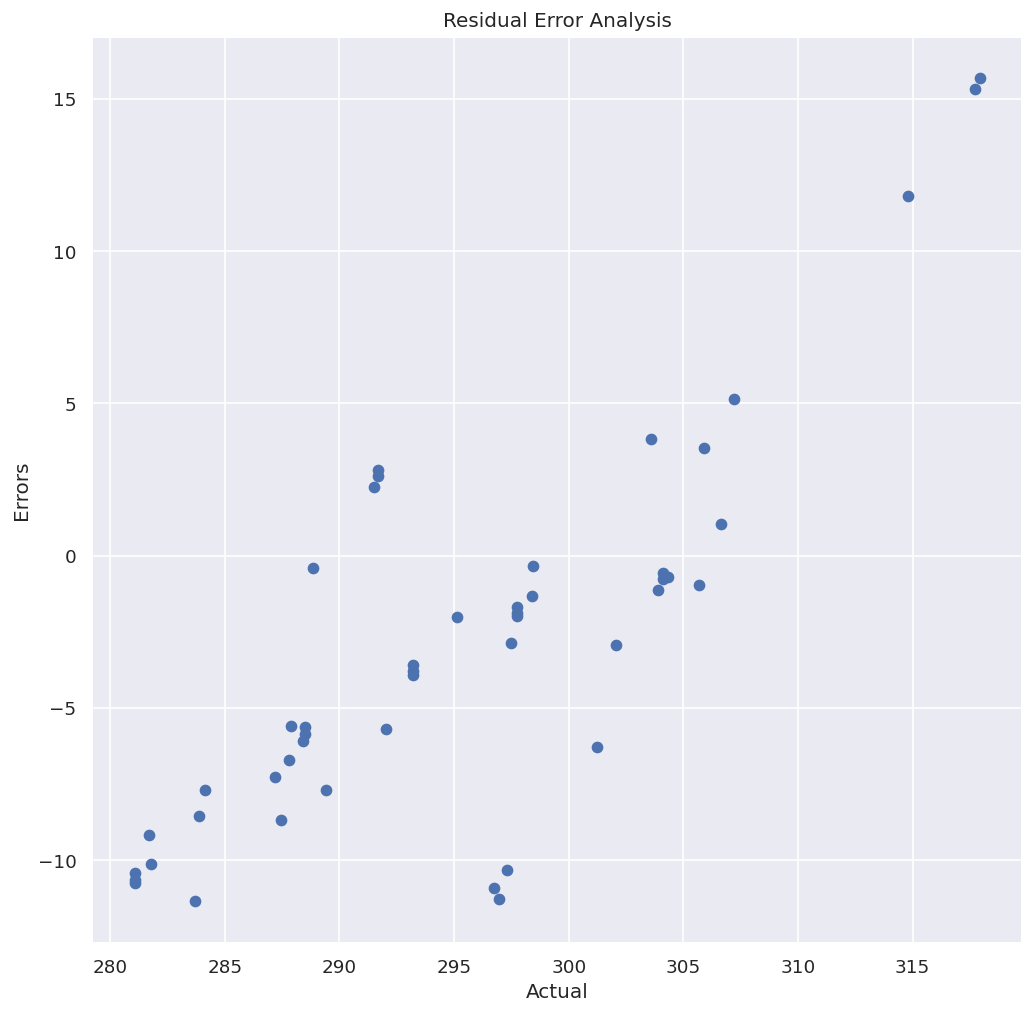

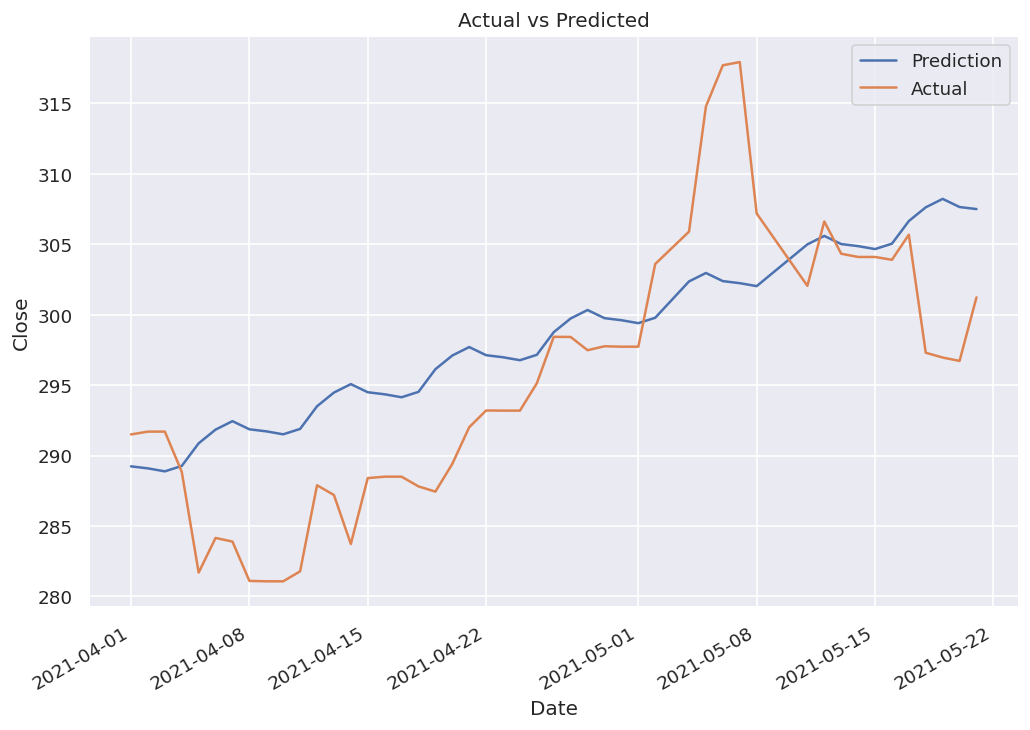

In [84]:
actuals = pd.Series(y_test, index=y_test.index)
prophet_results = evaluate_model(actuals, predictions, input_target_variable = input_target_variable)

In [85]:
results['Fbprophet'] = pd.Series(prophet_results)
results

auto_arima  auto_sarima  simple_exponential_smoothing  \
MAPE                   2.203311     2.160639                      2.651404   
RMSE                   7.814215     7.704300                     10.124945   
MAE                    6.450291     6.327245                      7.951059   
R2 Score               0.304538     0.323965                     -0.167583   
Durbin Watson Score    0.188198     0.192886                      0.112485   

                     double_exponential_smoothing  holt_winters  \
MAPE                                     2.203311      2.307885   
RMSE                                     7.814215      8.065159   
MAE                                      6.450291      6.753499   
R2 Score                                 0.304538      0.259153   
Durbin Watson Score                      0.188198      0.183083   

                     Linear regression with feature engineering  \
MAPE                                                   1.963382   
RMSE                                                   7.836058   
MAE                                                    5.865084   
R2 Score                                               0.300645   
Durbin Watson Score                                    0.528457   

                     Linear regression with tsfresh  Fbprophet  
MAPE                                       1.689281   1.925853  
RMSE                                       6.206836   7.001678  
MAE                                        4.991431   5.660817  
R2 Score                                   0.567703   0.449894  
Durbin Watson Score                        0.603202   0.256223

__Step's coclusion__

Prophet without hyperparameter tuning gives one of the worst results, but after tuning it gives second best result.

## 7.0 GluonTS (deep learning Amazon)

The GluonTS toolkit contains components and tools for building time series models using MXNet. 

In [124]:
import mxnet as mx
from mxnet import gluon
from gluonts.dataset.common import ListDataset

from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import json

In [94]:
df_train = df.set_index(input_date_variable)["2020-04-01":'2021-03-31'].reset_index()
df_test = df.set_index(input_date_variable)["2021-04-01":'2021-05-22'].reset_index()

start_train = df_train[input_date_variable].iloc[0]
start_test = df_test[input_date_variable].iloc[0]

In [128]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
freq='1d'
train_ds = ListDataset(
    [{"start": start_train, "target": df_train[input_target_variable]}],
    freq = freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"start": start_test, "target": df_test[input_target_variable]}],
    freq = freq
)

In [139]:
estimator = SimpleFeedForwardEstimator(freq=freq, 
                            prediction_length=len(df_test), 
                            trainer=Trainer(epochs=20))

In [140]:
predictor = estimator.train(train_ds)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:gluonts.trainer:Number of parameters in SimpleFeedForwardTrainingNetwork: 80803


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:00<00:00, 104.25it/s, epoch=1/20, avg_epoch_loss=5.65]
INFO:gluonts.trainer:Epoch[0] Elapsed time 0.484 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=5.646789
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 112.42it/s, epoch=2/20, avg_epoch_loss=4.6]
INFO:gluonts.trainer:Epoch[1] Elapsed time 0.450 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=4.596304
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 113.65it/s, epoch=3/20, avg_epoch_loss=4.48]
INFO:gluonts.trainer:Epoch[2] Elapsed time 0.446 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=4.484921
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 114.24it/s, epoch=4/20, avg_epoch_loss=4.37]
INFO:gluonts.trainer:Epoch[3] Elapsed time 0.444 seconds
INFO:gluonts.trainer:Epoch[3] Evaluation metric 'epoch_loss'=4.367671
INFO:g

In [141]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=len(test_ds),  # number of sample paths we want for evaluation
)

In [142]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

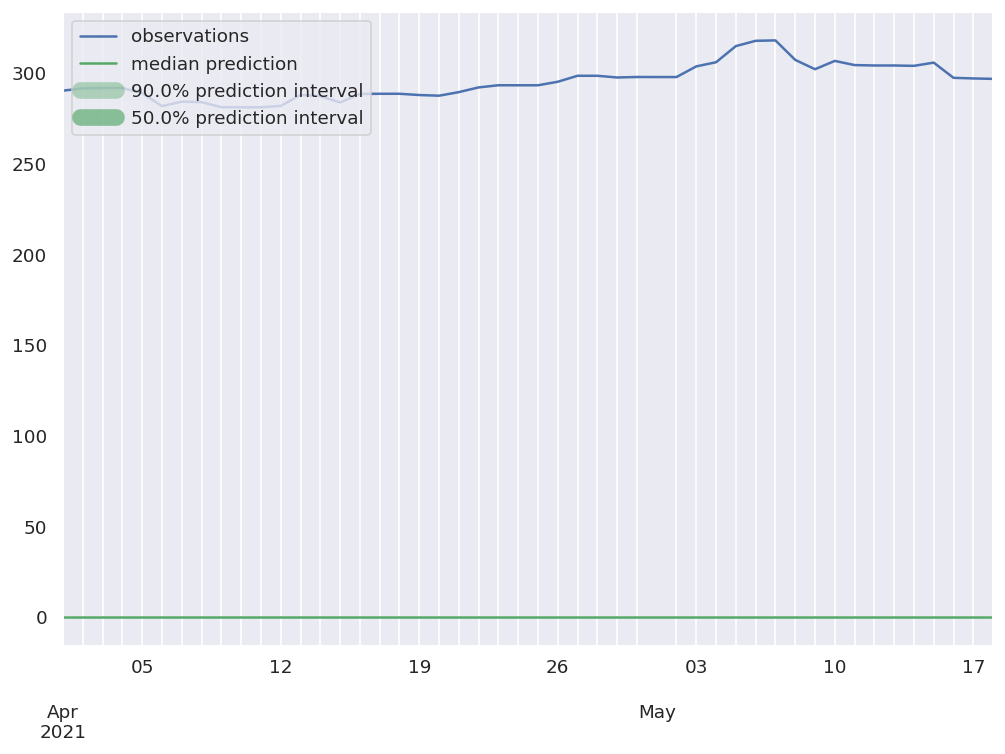

In [143]:
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]
plot_prob_forecasts(ts_entry, forecast_entry)

In [144]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 26.65it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:80: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/metrics.py:157: RuntimeWarning:

divide by zero encountered in true_divide


/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1625: UserWarning:




In [125]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 87123.18229166667,
    "abs_error": 14160.759765625,
    "abs_target_sum": 14160.759765625,
    "abs_target_mean": 295.0158284505208,
    "seasonal_error": NaN,
    "MASE": NaN,
    "MAPE": 1.0,
    "sMAPE": 2.0,
    "OWA": NaN,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2832.152026367188,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 14160.760131835938,
    "Coverage[0.5]": 0.0,
    "QuantileLoss[0.9]": 25489.368237304687,
    "Coverage[0.9]": 0.0,
    "RMSE": 295.1663637538442,
    "NRMSE": 1.000510261785322,
    "ND": 1.0,
    "wQuantileLoss[0.1]": 0.20000000517219338,
    "wQuantileLoss[0.5]": 1.0000000258609667,
    "wQuantileLoss[0.9]": 1.80000004654974,
    "mean_absolute_QuantileLoss": 14160.760131835938,
    "mean_wQuantileLoss": 1.0000000258609667,
    "MAE_Coverage": 0.5
}


In [ ]:
__Step's coclusion__

## 8.0 Manual Deep learning Model

https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca

In [ ]:
https://medium.com/analytics-vidhya/pytorch-lstms-for-time-series-forecasting-of-indian-stocks-8a49157da8b9

In [ ]:
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [ ]:
__Step's coclusion__

## 9.0 Compare results

In [ ]:
__Step's coclusion__